In [2]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from models.ffnn import FeedForwardNN
from utils.dataset import load_mnist
from configs.config_loader import load_config
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

In [3]:
# Load dataset
X_train, X_test, y_train, y_test = load_mnist()
val_size = int(len(X_train) * 0.2)
X_val, y_val = X_train[:val_size], y_train[:val_size]
X_train, y_train = X_train[val_size:], y_train[val_size:]

Original split - Train: 60000, Test: 10000


In [7]:
def compute_accuracy(model, X, y):
    predictions = model.forward(X, training=False)
    return np.mean(np.argmax(predictions, axis=1) == np.argmax(y, axis=1))

def train_and_evaluate(config):
    # Create model with base parameters
    model = FeedForwardNN(
        input_size=config['model']['input_size'],
        hidden_layers=config['model']['hidden_layers'],
        output_size=config['model']['output_size'],
        activations=config['model']['activations'],
        weight_init=config['model']['weight_init'],
        weight_init_params=config.get('weight_init_params', None),
        loss_function=config['model']['loss_function']
    )
    
    # Apply regularization if implemented in the model
    if hasattr(model, 'set_regularization'):
        if 'regularization' in config['model'] and config['model']['regularization']:
            if config['model']['regularization'] == 'l1':
                lambda_val = config['model'].get('lambda_l1', 0.0)
                model.set_regularization('l1', lambda_val)
            elif config['model']['regularization'] == 'l2':
                lambda_val = config['model'].get('lambda_l2', 0.0)
                model.set_regularization('l2', lambda_val)
    
    # Train model
    history = model.train(
        X_train, y_train,
        X_val=X_val, y_val=y_val,
        batch_size=config['training']['batch_size'],
        learning_rate=config['training']['learning_rate'],
        epochs=config['training']['epochs'],
        verbose=config['training']['verbose']
    )
    
    # Evaluate model
    train_acc = compute_accuracy(model, X_train, y_train)
    val_acc = compute_accuracy(model, X_val, y_val)
    test_acc = compute_accuracy(model, X_test, y_test)
    
    return model, history, (train_acc, val_acc, test_acc)

def summarize_results(results_dict, title):
    """Visualize accuracy results for each experiment"""
    names = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    
    for name, res in results_dict.items():
        train_acc, val_acc, test_acc = res['accs']
        names.append(name)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)

    plt.figure(figsize=(12, 6))
    x = np.arange(len(names))
    width = 0.25
    
    plt.bar(x - width, train_accuracies, width, label='Train', color='skyblue')
    plt.bar(x, val_accuracies, width, label='Validation', color='lightgreen')
    plt.bar(x + width, test_accuracies, width, label='Test', color='salmon')
    
    plt.xlabel('Configuration')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.xticks(x, names, rotation=45)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print detailed results in table format
    print("\nDetailed results:")
    print(f"{'Configuration':<20} {'Train Acc':<10} {'Val Acc':<10} {'Test Acc':<10}")
    print("-" * 50)
    for i, name in enumerate(names):
        print(f"{name:<20} {train_accuracies[i]:.4f}     {val_accuracies[i]:.4f}     {test_accuracies[i]:.4f}")

def plot_loss_histories(results_dict, title):
    """Plot training and validation loss curves"""
    plt.figure(figsize=(12, 6))
    
    for name, res in results_dict.items():
        plt.plot(res['history']['train_loss'], label=f"{name} - Train")
        if 'val_loss' in res['history']:
            plt.plot(res['history']['val_loss'], linestyle='--', label=f"{name} - Val")

    plt.title(f'Training Loss vs Validation Loss ({title})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def visualize_weight_distribution(model, layer_idx, title):
    """Visualize weight distribution for a specific layer"""
    if layer_idx < len(model.layers):
        weights = model.layers[layer_idx].weights.flatten()
        
        plt.figure(figsize=(10, 5))
        plt.hist(weights, bins=50, alpha=0.7, color='blue')
        plt.title(f"{title} - Layer {layer_idx+1} Weight Distribution")
        plt.xlabel('Weight Value')
        plt.ylabel('Frequency')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print(f"Weight stats for {title} - Layer {layer_idx+1}:")
        print(f"  Mean: {np.mean(weights):.6f}")
        print(f"  Std Dev: {np.std(weights):.6f}")
        print(f"  Min: {np.min(weights):.6f}")
        print(f"  Max: {np.max(weights):.6f}")
    else:
        print(f"Layer index {layer_idx} out of range for model with {len(model.layers)} layers")

def visualize_gradient_distribution(model, X_batch, y_batch, layer_idx, title):
    """Generate and visualize gradient distribution for a specific layer"""
    # Forward pass
    y_pred = model.forward(X_batch, training=True)
    
    # Backward pass to generate gradients
    model.backward(y_pred, y_batch)
    
    # Get gradients if available
    if hasattr(model.layers[layer_idx], 'dW'):
        gradients = model.layers[layer_idx].dW.flatten()
        
        plt.figure(figsize=(10, 5))
        plt.hist(gradients, bins=50, alpha=0.7, color='green')
        plt.title(f"{title} - Layer {layer_idx+1} Gradient Distribution")
        plt.xlabel('Gradient Value')
        plt.ylabel('Frequency')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
        
        # Print statistics
        print(f"Gradient stats for {title} - Layer {layer_idx+1}:")
        print(f"  Mean: {np.mean(gradients):.6f}")
        print(f"  Std Dev: {np.std(gradients):.6f}")
        print(f"  Min: {np.min(gradients):.6f}")
        print(f"  Max: {np.max(gradients):.6f}")
    else:
        print(f"No gradient (dW) attribute found for layer {layer_idx+1}")

def visualize_model_distributions(results_dict, title):
    """Visualize weight and gradient distributions for all models in results"""
    X_batch = X_train[:32]  # Small batch for generating gradients
    y_batch = y_train[:32]
    
    for name, res in results_dict.items():
        if 'model' in res:
            model = res['model']
            print(f"\n===== {title} - {name} =====")
            
            # Visualize weights for each layer
            for i in range(len(model.layers)):
                visualize_weight_distribution(model, i, f"{name}")
            
            # Visualize gradients for each layer
            for i in range(len(model.layers)):
                visualize_gradient_distribution(model, X_batch, y_batch, i, f"{name}")

# Load the base configuration
base_config = {
    'model': {
        'input_size': 784,
        'hidden_layers': [256, 128, 64],
        'output_size': 10,
        'activations': ["relu", "relu", "relu", "softmax"],
        'weight_init': "xavier",
        'loss_function': "categorical_crossentropy",
        'lambda_l1': 0.0,
        'lambda_l2': 1e-5
    },
    'training': {
        'batch_size': 32,
        'learning_rate': 0.01,
        'epochs': 10,
        'verbose': 1
    },
    'weight_init_params': {
        'lower_bound': -0.1,
        'upper_bound': 0.1,
        'seed': 42,
        'mean': 0,
        'variance': 0.1
    },
    'data': {
        'validation_split': 0.2
    },
    'save': {
        'model_path': "models/saved_model.npy",
        'save_frequency': 10
    }
}


===== EXPERIMENT: DEPTH AND WIDTH =====

Training model with Width 64x2...


Epoch 1/10: 100%|██████████| 1500/1500 [00:00<00:00, 1700.83it/s]


 - train_loss: 0.7797 - val_loss: 0.3901


Epoch 2/10: 100%|██████████| 1500/1500 [00:00<00:00, 1891.90it/s]


 - train_loss: 0.3469 - val_loss: 0.3053


Epoch 3/10: 100%|██████████| 1500/1500 [00:00<00:00, 1869.63it/s]


 - train_loss: 0.2914 - val_loss: 0.2688


Epoch 4/10: 100%|██████████| 1500/1500 [00:00<00:00, 1812.06it/s]


 - train_loss: 0.2581 - val_loss: 0.2442


Epoch 5/10: 100%|██████████| 1500/1500 [00:00<00:00, 1993.34it/s]


 - train_loss: 0.2322 - val_loss: 0.2213


Epoch 6/10: 100%|██████████| 1500/1500 [00:00<00:00, 1645.71it/s]


 - train_loss: 0.2114 - val_loss: 0.2067


Epoch 7/10: 100%|██████████| 1500/1500 [00:00<00:00, 1646.60it/s]


 - train_loss: 0.1937 - val_loss: 0.1988


Epoch 8/10: 100%|██████████| 1500/1500 [00:00<00:00, 1914.64it/s]


 - train_loss: 0.1783 - val_loss: 0.1807


Epoch 9/10: 100%|██████████| 1500/1500 [00:00<00:00, 1948.05it/s]


 - train_loss: 0.1654 - val_loss: 0.1705


Epoch 10/10: 100%|██████████| 1500/1500 [00:00<00:00, 1969.46it/s]


 - train_loss: 0.1540 - val_loss: 0.1607

Training model with Width 128x2...


Epoch 1/10: 100%|██████████| 1500/1500 [00:01<00:00, 1127.34it/s]


 - train_loss: 0.7355 - val_loss: 0.3701


Epoch 2/10: 100%|██████████| 1500/1500 [00:01<00:00, 1044.09it/s]


 - train_loss: 0.3293 - val_loss: 0.2871


Epoch 3/10: 100%|██████████| 1500/1500 [00:01<00:00, 1076.02it/s]


 - train_loss: 0.2749 - val_loss: 0.2516


Epoch 4/10: 100%|██████████| 1500/1500 [00:01<00:00, 952.87it/s]


 - train_loss: 0.2401 - val_loss: 0.2237


Epoch 5/10: 100%|██████████| 1500/1500 [00:01<00:00, 1095.16it/s]


 - train_loss: 0.2128 - val_loss: 0.2076


Epoch 6/10: 100%|██████████| 1500/1500 [00:01<00:00, 889.83it/s] 


 - train_loss: 0.1901 - val_loss: 0.1924


Epoch 7/10: 100%|██████████| 1500/1500 [00:01<00:00, 1080.78it/s]


 - train_loss: 0.1712 - val_loss: 0.1736


Epoch 8/10: 100%|██████████| 1500/1500 [00:01<00:00, 880.66it/s]


 - train_loss: 0.1564 - val_loss: 0.1620


Epoch 9/10: 100%|██████████| 1500/1500 [00:01<00:00, 1114.68it/s]


 - train_loss: 0.1428 - val_loss: 0.1554


Epoch 10/10: 100%|██████████| 1500/1500 [00:01<00:00, 938.48it/s]


 - train_loss: 0.1317 - val_loss: 0.1439

Training model with Width 256x2...


Epoch 1/10: 100%|██████████| 1500/1500 [00:03<00:00, 384.71it/s]


 - train_loss: 0.6602 - val_loss: 0.3308


Epoch 2/10: 100%|██████████| 1500/1500 [00:03<00:00, 392.47it/s]


 - train_loss: 0.3048 - val_loss: 0.2641


Epoch 3/10: 100%|██████████| 1500/1500 [00:03<00:00, 403.05it/s]


 - train_loss: 0.2523 - val_loss: 0.2276


Epoch 4/10: 100%|██████████| 1500/1500 [00:04<00:00, 359.57it/s]


 - train_loss: 0.2178 - val_loss: 0.2042


Epoch 5/10: 100%|██████████| 1500/1500 [00:03<00:00, 396.55it/s]


 - train_loss: 0.1918 - val_loss: 0.1858


Epoch 6/10: 100%|██████████| 1500/1500 [00:03<00:00, 389.36it/s]


 - train_loss: 0.1710 - val_loss: 0.1743


Epoch 7/10: 100%|██████████| 1500/1500 [00:04<00:00, 367.45it/s]


 - train_loss: 0.1550 - val_loss: 0.1551


Epoch 8/10: 100%|██████████| 1500/1500 [00:04<00:00, 366.34it/s]


 - train_loss: 0.1405 - val_loss: 0.1468


Epoch 9/10: 100%|██████████| 1500/1500 [00:03<00:00, 403.56it/s]


 - train_loss: 0.1288 - val_loss: 0.1410


Epoch 10/10: 100%|██████████| 1500/1500 [00:03<00:00, 390.59it/s]


 - train_loss: 0.1181 - val_loss: 0.1359

Training model with Depth 1x128...


Epoch 1/10: 100%|██████████| 1500/1500 [00:01<00:00, 1205.28it/s]


 - train_loss: 0.7176 - val_loss: 0.3898


Epoch 2/10: 100%|██████████| 1500/1500 [00:01<00:00, 1112.74it/s]


 - train_loss: 0.3600 - val_loss: 0.3151


Epoch 3/10: 100%|██████████| 1500/1500 [00:01<00:00, 1184.36it/s]


 - train_loss: 0.3061 - val_loss: 0.2802


Epoch 4/10: 100%|██████████| 1500/1500 [00:01<00:00, 1175.53it/s]


 - train_loss: 0.2747 - val_loss: 0.2556


Epoch 5/10: 100%|██████████| 1500/1500 [00:01<00:00, 1299.31it/s]


 - train_loss: 0.2519 - val_loss: 0.2386


Epoch 6/10: 100%|██████████| 1500/1500 [00:01<00:00, 1204.47it/s]


 - train_loss: 0.2333 - val_loss: 0.2246


Epoch 7/10: 100%|██████████| 1500/1500 [00:01<00:00, 1344.04it/s]


 - train_loss: 0.2179 - val_loss: 0.2110


Epoch 8/10: 100%|██████████| 1500/1500 [00:01<00:00, 1016.01it/s]


 - train_loss: 0.2046 - val_loss: 0.2012


Epoch 9/10: 100%|██████████| 1500/1500 [00:01<00:00, 1310.33it/s]


 - train_loss: 0.1929 - val_loss: 0.1918


Epoch 10/10: 100%|██████████| 1500/1500 [00:01<00:00, 1171.39it/s]


 - train_loss: 0.1824 - val_loss: 0.1831

Training model with Depth 2x128...


Epoch 1/10: 100%|██████████| 1500/1500 [00:01<00:00, 963.48it/s]


 - train_loss: 0.7143 - val_loss: 0.3496


Epoch 2/10: 100%|██████████| 1500/1500 [00:01<00:00, 1102.94it/s]


 - train_loss: 0.3223 - val_loss: 0.2816


Epoch 3/10: 100%|██████████| 1500/1500 [00:01<00:00, 1038.77it/s]


 - train_loss: 0.2686 - val_loss: 0.2424


Epoch 4/10: 100%|██████████| 1500/1500 [00:01<00:00, 935.69it/s] 


 - train_loss: 0.2354 - val_loss: 0.2179


Epoch 5/10: 100%|██████████| 1500/1500 [00:01<00:00, 915.14it/s]


 - train_loss: 0.2092 - val_loss: 0.1967


Epoch 6/10: 100%|██████████| 1500/1500 [00:01<00:00, 1076.17it/s]


 - train_loss: 0.1883 - val_loss: 0.1807


Epoch 7/10: 100%|██████████| 1500/1500 [00:01<00:00, 1097.00it/s]


 - train_loss: 0.1715 - val_loss: 0.1686


Epoch 8/10: 100%|██████████| 1500/1500 [00:01<00:00, 890.66it/s]


 - train_loss: 0.1563 - val_loss: 0.1603


Epoch 9/10: 100%|██████████| 1500/1500 [00:01<00:00, 940.08it/s]


 - train_loss: 0.1437 - val_loss: 0.1510


Epoch 10/10: 100%|██████████| 1500/1500 [00:01<00:00, 857.21it/s]


 - train_loss: 0.1327 - val_loss: 0.1431

Training model with Depth 3x128...


Epoch 1/10: 100%|██████████| 1500/1500 [00:01<00:00, 835.19it/s]


 - train_loss: 0.7458 - val_loss: 0.3256


Epoch 2/10: 100%|██████████| 1500/1500 [00:01<00:00, 905.65it/s]


 - train_loss: 0.2991 - val_loss: 0.2639


Epoch 3/10: 100%|██████████| 1500/1500 [00:01<00:00, 947.47it/s]


 - train_loss: 0.2433 - val_loss: 0.2179


Epoch 4/10: 100%|██████████| 1500/1500 [00:01<00:00, 776.06it/s]


 - train_loss: 0.2076 - val_loss: 0.1960


Epoch 5/10: 100%|██████████| 1500/1500 [00:01<00:00, 830.40it/s]


 - train_loss: 0.1811 - val_loss: 0.1722


Epoch 6/10: 100%|██████████| 1500/1500 [00:02<00:00, 671.47it/s]


 - train_loss: 0.1599 - val_loss: 0.1615


Epoch 7/10: 100%|██████████| 1500/1500 [00:02<00:00, 589.55it/s]


 - train_loss: 0.1426 - val_loss: 0.1463


Epoch 8/10: 100%|██████████| 1500/1500 [00:02<00:00, 556.70it/s]


 - train_loss: 0.1284 - val_loss: 0.1462


Epoch 9/10: 100%|██████████| 1500/1500 [00:02<00:00, 557.17it/s]


 - train_loss: 0.1162 - val_loss: 0.1309


Epoch 10/10: 100%|██████████| 1500/1500 [00:02<00:00, 639.50it/s]


 - train_loss: 0.1061 - val_loss: 0.1292


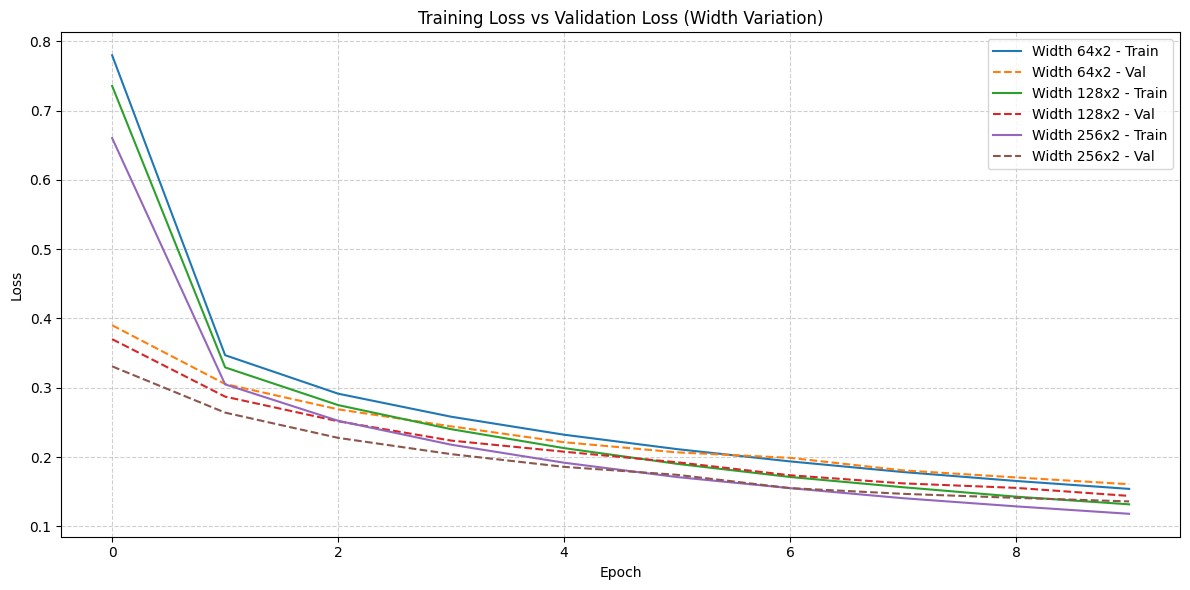

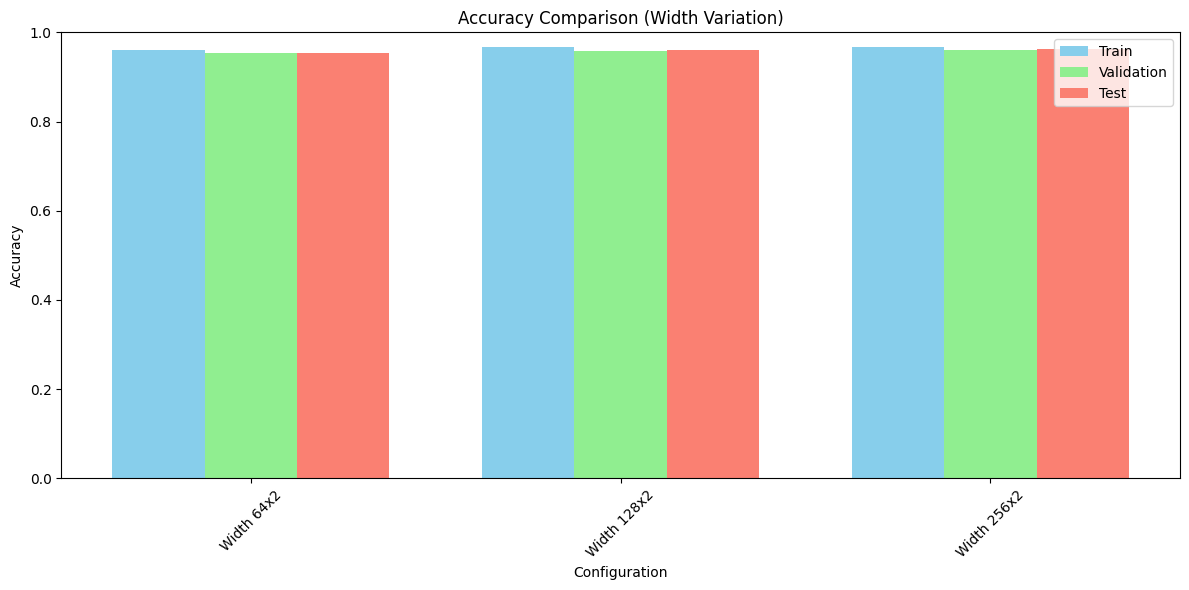


Detailed results:
Configuration        Train Acc  Val Acc    Test Acc  
--------------------------------------------------
Width 64x2           0.9599     0.9539     0.9541
Width 128x2          0.9662     0.9592     0.9600
Width 256x2          0.9679     0.9608     0.9616


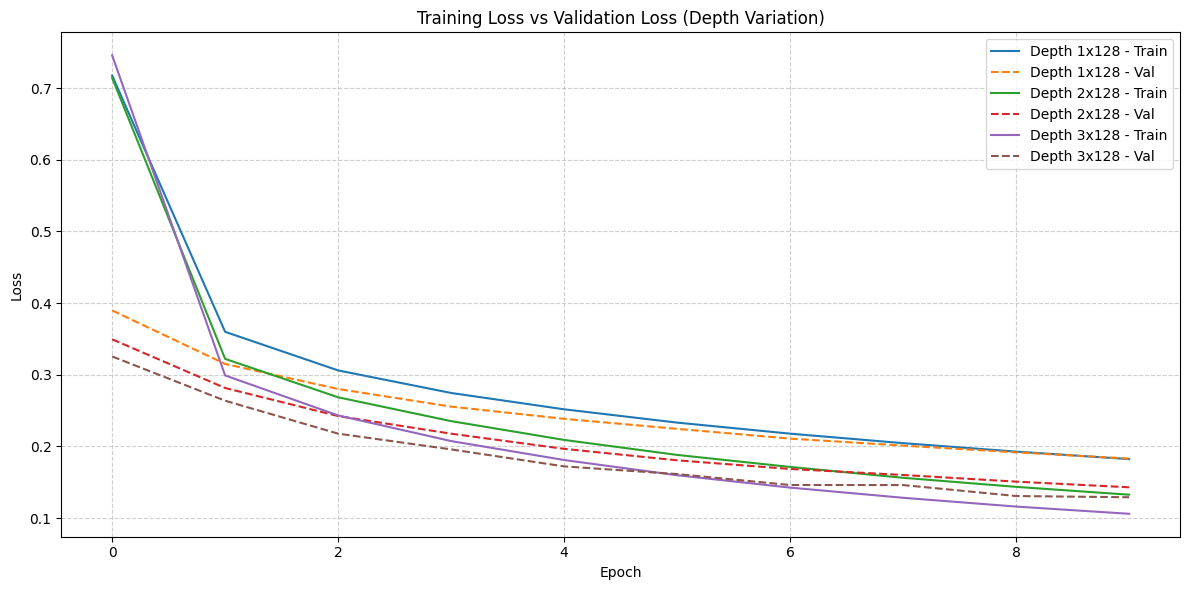

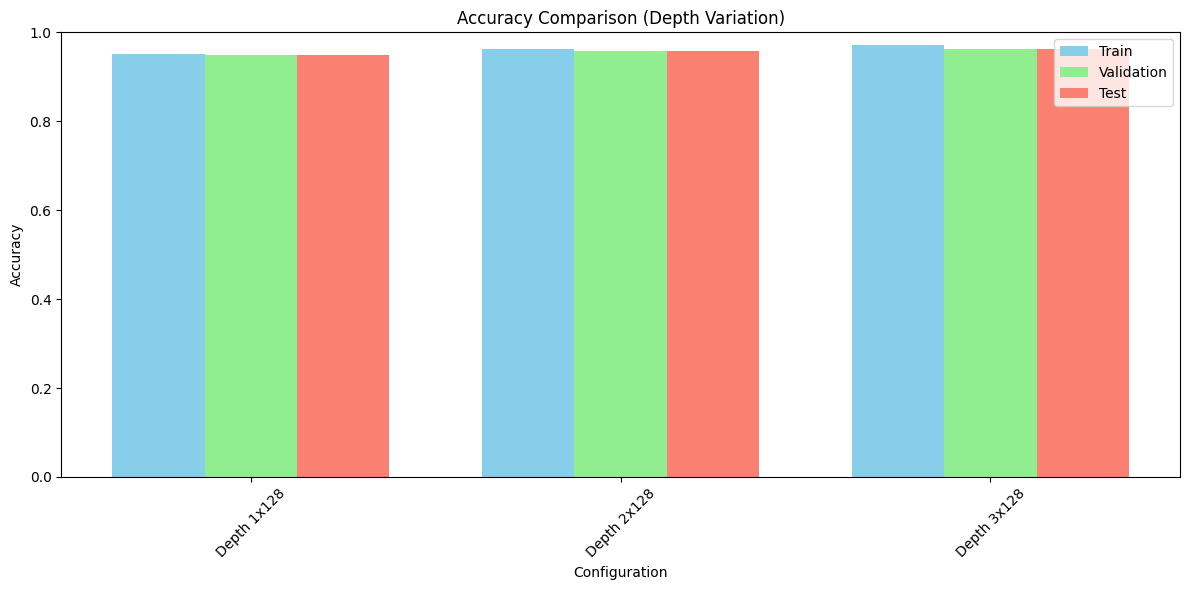


Detailed results:
Configuration        Train Acc  Val Acc    Test Acc  
--------------------------------------------------
Depth 1x128          0.9511     0.9485     0.9490
Depth 2x128          0.9635     0.9571     0.9586
Depth 3x128          0.9718     0.9617     0.9636


In [8]:
# 1. Experiment: Depth and Width
print("\n===== EXPERIMENT: DEPTH AND WIDTH =====")

# Width experiment (fixed 2-layer depth)
width_configs = [
    {'hidden_layers': [64, 64], 'name': 'Width 64x2'},
    {'hidden_layers': [128, 128], 'name': 'Width 128x2'},
    {'hidden_layers': [256, 256], 'name': 'Width 256x2'}
]

width_results = {}
for cfg in width_configs:
    print(f"\nTraining model with {cfg['name']}...")
    modified_config = copy.deepcopy(base_config)
    modified_config['model']['hidden_layers'] = cfg['hidden_layers']
    modified_config['model']['activations'] = ['relu'] * len(cfg['hidden_layers']) + ['softmax']
    model, history, accs = train_and_evaluate(modified_config)
    width_results[cfg['name']] = {'history': history, 'accs': accs, 'model': model}

# Depth experiment (fixed 128 neurons per layer)
depth_configs = [
    {'hidden_layers': [128], 'name': 'Depth 1x128'},
    {'hidden_layers': [128, 128], 'name': 'Depth 2x128'},
    {'hidden_layers': [128, 128, 128], 'name': 'Depth 3x128'}
]

depth_results = {}
for cfg in depth_configs:
    print(f"\nTraining model with {cfg['name']}...")
    modified_config = copy.deepcopy(base_config)
    modified_config['model']['hidden_layers'] = cfg['hidden_layers']
    modified_config['model']['activations'] = ['relu'] * len(cfg['hidden_layers']) + ['softmax']
    model, history, accs = train_and_evaluate(modified_config)
    depth_results[cfg['name']] = {'history': history, 'accs': accs, 'model': model}

# Plot results
plot_loss_histories(width_results, "Width Variation")
summarize_results(width_results, 'Accuracy Comparison (Width Variation)')

plot_loss_histories(depth_results, "Depth Variation")
summarize_results(depth_results, 'Accuracy Comparison (Depth Variation)')


===== EXPERIMENT: ACTIVATION FUNCTIONS =====

Training model with Sigmoid activation...


Epoch 1/10: 100%|██████████| 1500/1500 [00:04<00:00, 320.13it/s]


 - train_loss: 2.2975 - val_loss: 2.2867


Epoch 2/10: 100%|██████████| 1500/1500 [00:05<00:00, 284.49it/s]


 - train_loss: 2.2775 - val_loss: 2.2639


Epoch 3/10: 100%|██████████| 1500/1500 [00:04<00:00, 300.38it/s]


 - train_loss: 2.2446 - val_loss: 2.2150


Epoch 4/10: 100%|██████████| 1500/1500 [00:04<00:00, 316.93it/s]


 - train_loss: 2.1580 - val_loss: 2.0624


Epoch 5/10: 100%|██████████| 1500/1500 [00:04<00:00, 323.76it/s]


 - train_loss: 1.8954 - val_loss: 1.6804


Epoch 6/10: 100%|██████████| 1500/1500 [00:04<00:00, 329.78it/s]


 - train_loss: 1.5132 - val_loss: 1.3478


Epoch 7/10: 100%|██████████| 1500/1500 [00:04<00:00, 326.80it/s]


 - train_loss: 1.2488 - val_loss: 1.1268


Epoch 8/10: 100%|██████████| 1500/1500 [00:04<00:00, 326.20it/s]


 - train_loss: 1.0403 - val_loss: 0.9351


Epoch 9/10: 100%|██████████| 1500/1500 [00:05<00:00, 293.31it/s]


 - train_loss: 0.8745 - val_loss: 0.8010


Epoch 10/10: 100%|██████████| 1500/1500 [00:05<00:00, 297.58it/s]


 - train_loss: 0.7628 - val_loss: 0.7104

Training model with Tanh activation...


Epoch 1/10: 100%|██████████| 1500/1500 [00:04<00:00, 333.31it/s]


 - train_loss: 0.5808 - val_loss: 0.3343


Epoch 2/10: 100%|██████████| 1500/1500 [00:04<00:00, 338.45it/s]


 - train_loss: 0.3129 - val_loss: 0.2709


Epoch 3/10: 100%|██████████| 1500/1500 [00:04<00:00, 337.57it/s]


 - train_loss: 0.2637 - val_loss: 0.2389


Epoch 4/10: 100%|██████████| 1500/1500 [00:04<00:00, 360.34it/s]


 - train_loss: 0.2324 - val_loss: 0.2147


Epoch 5/10: 100%|██████████| 1500/1500 [00:04<00:00, 350.64it/s]


 - train_loss: 0.2078 - val_loss: 0.1970


Epoch 6/10: 100%|██████████| 1500/1500 [00:04<00:00, 331.04it/s]


 - train_loss: 0.1873 - val_loss: 0.1815


Epoch 7/10: 100%|██████████| 1500/1500 [00:04<00:00, 372.32it/s]


 - train_loss: 0.1712 - val_loss: 0.1693


Epoch 8/10: 100%|██████████| 1500/1500 [00:04<00:00, 354.47it/s]


 - train_loss: 0.1567 - val_loss: 0.1582


Epoch 9/10: 100%|██████████| 1500/1500 [00:04<00:00, 374.46it/s]


 - train_loss: 0.1448 - val_loss: 0.1498


Epoch 10/10: 100%|██████████| 1500/1500 [00:03<00:00, 403.52it/s]


 - train_loss: 0.1341 - val_loss: 0.1413

Training model with ReLU activation...


Epoch 1/10: 100%|██████████| 1500/1500 [00:03<00:00, 472.29it/s]


 - train_loss: 0.6785 - val_loss: 0.3201


Epoch 2/10: 100%|██████████| 1500/1500 [00:03<00:00, 467.52it/s]


 - train_loss: 0.2752 - val_loss: 0.2343


Epoch 3/10: 100%|██████████| 1500/1500 [00:03<00:00, 472.60it/s]


 - train_loss: 0.2155 - val_loss: 0.1974


Epoch 4/10: 100%|██████████| 1500/1500 [00:03<00:00, 433.14it/s]


 - train_loss: 0.1784 - val_loss: 0.1732


Epoch 5/10: 100%|██████████| 1500/1500 [00:03<00:00, 377.04it/s]


 - train_loss: 0.1526 - val_loss: 0.1539


Epoch 6/10: 100%|██████████| 1500/1500 [00:03<00:00, 375.77it/s]


 - train_loss: 0.1328 - val_loss: 0.1396


Epoch 7/10: 100%|██████████| 1500/1500 [00:03<00:00, 398.23it/s]


 - train_loss: 0.1170 - val_loss: 0.1261


Epoch 8/10: 100%|██████████| 1500/1500 [00:04<00:00, 349.95it/s]


 - train_loss: 0.1036 - val_loss: 0.1208


Epoch 9/10: 100%|██████████| 1500/1500 [00:04<00:00, 359.23it/s]


 - train_loss: 0.0926 - val_loss: 0.1183


Epoch 10/10: 100%|██████████| 1500/1500 [00:05<00:00, 299.47it/s]


 - train_loss: 0.0839 - val_loss: 0.1073

Training model with Linear activation...


Epoch 1/10: 100%|██████████| 1500/1500 [00:04<00:00, 335.88it/s]


 - train_loss: 0.4837 - val_loss: 0.3300


Epoch 2/10: 100%|██████████| 1500/1500 [00:04<00:00, 317.38it/s]


 - train_loss: 0.3277 - val_loss: 0.3108


Epoch 3/10: 100%|██████████| 1500/1500 [00:04<00:00, 305.60it/s]


 - train_loss: 0.3074 - val_loss: 0.2925


Epoch 4/10: 100%|██████████| 1500/1500 [00:04<00:00, 307.63it/s]


 - train_loss: 0.2964 - val_loss: 0.2916


Epoch 5/10: 100%|██████████| 1500/1500 [00:05<00:00, 284.40it/s]


 - train_loss: 0.2890 - val_loss: 0.3056


Epoch 6/10: 100%|██████████| 1500/1500 [00:04<00:00, 303.15it/s]


 - train_loss: 0.2846 - val_loss: 0.2845


Epoch 7/10: 100%|██████████| 1500/1500 [00:04<00:00, 314.90it/s]


 - train_loss: 0.2799 - val_loss: 0.2889


Epoch 8/10: 100%|██████████| 1500/1500 [00:04<00:00, 321.07it/s]


 - train_loss: 0.2767 - val_loss: 0.2810


Epoch 9/10: 100%|██████████| 1500/1500 [00:04<00:00, 326.41it/s]


 - train_loss: 0.2748 - val_loss: 0.2812


Epoch 10/10: 100%|██████████| 1500/1500 [00:04<00:00, 306.87it/s]


 - train_loss: 0.2714 - val_loss: 0.2892


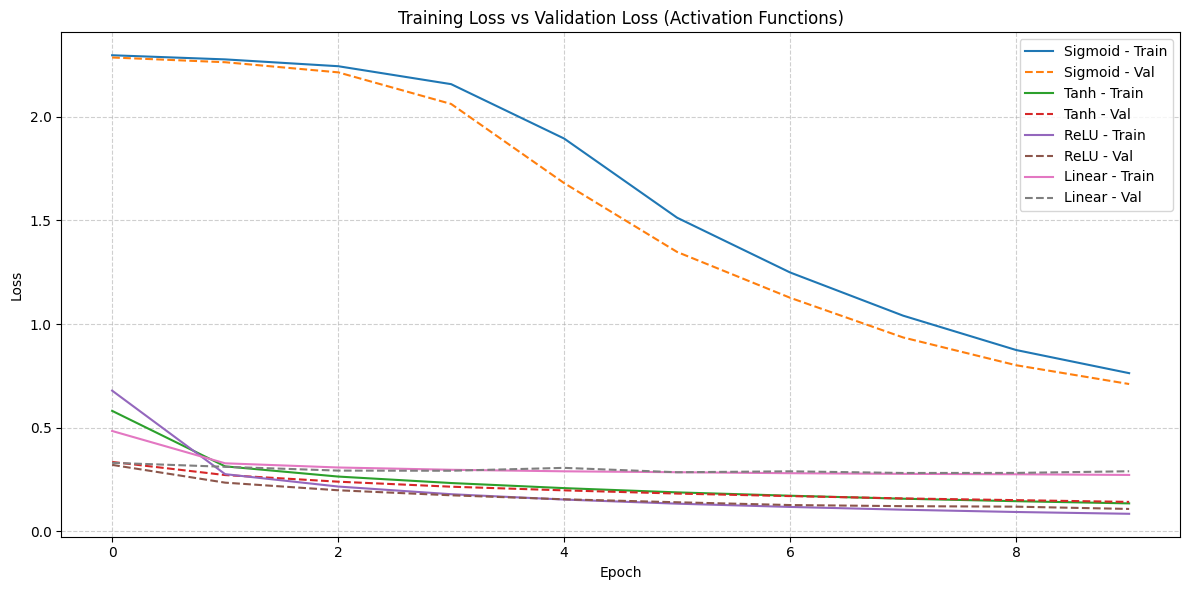

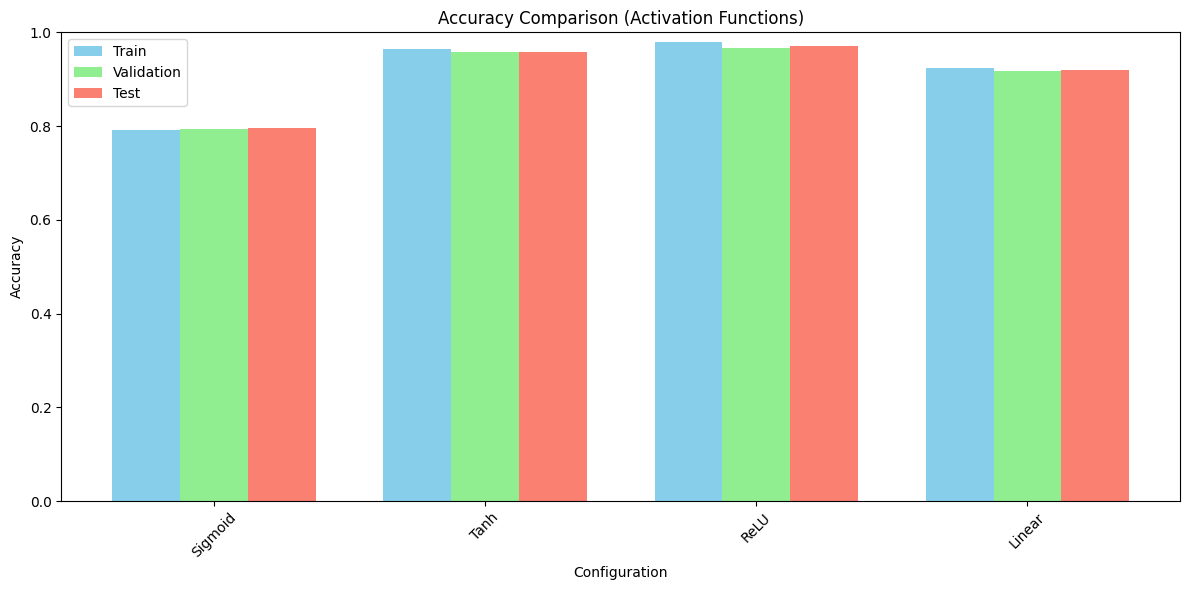


Detailed results:
Configuration        Train Acc  Val Acc    Test Acc  
--------------------------------------------------
Sigmoid              0.7919     0.7947     0.7969
Tanh                 0.9644     0.9590     0.9580
ReLU                 0.9800     0.9675     0.9700
Linear               0.9229     0.9173     0.9191

===== Activation Functions - Sigmoid =====


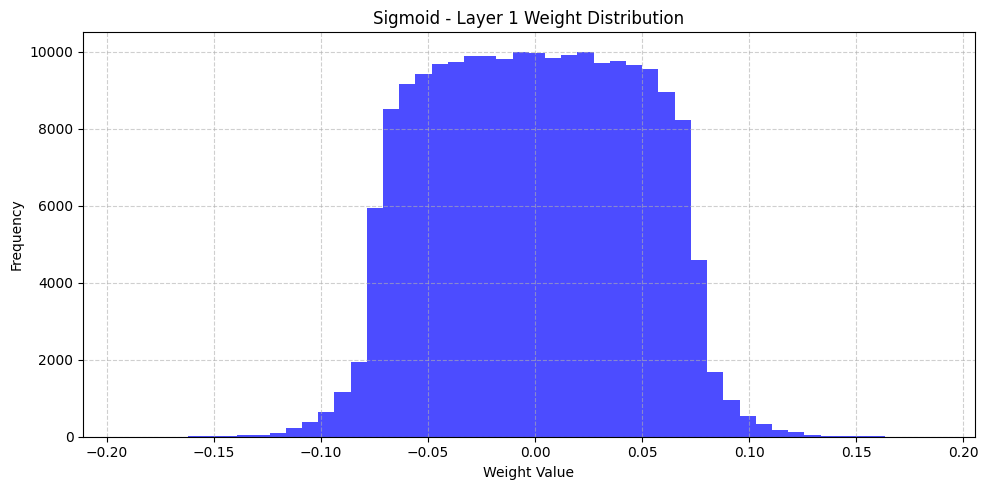

Weight stats for Sigmoid - Layer 1:
  Mean: -0.000081
  Std Dev: 0.046435
  Min: -0.192201
  Max: 0.186346


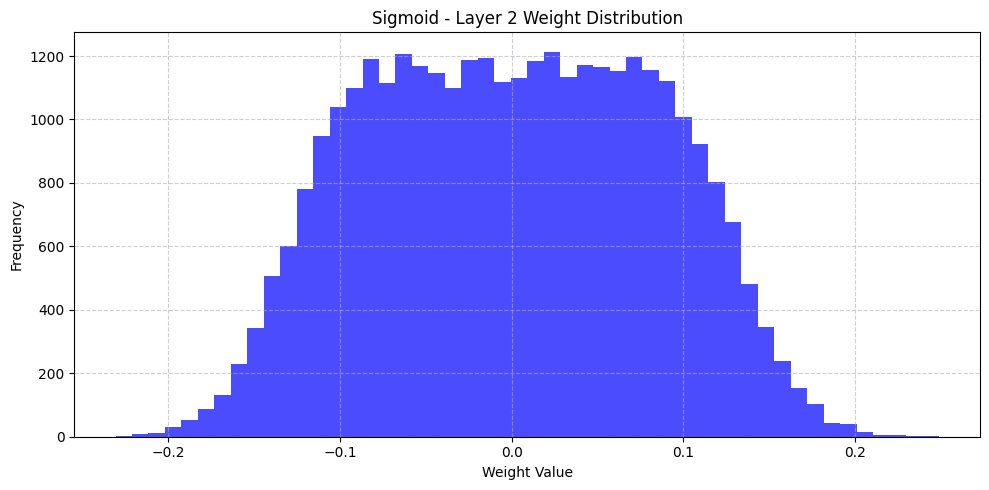

Weight stats for Sigmoid - Layer 2:
  Mean: -0.000015
  Std Dev: 0.083055
  Min: -0.230581
  Max: 0.248678


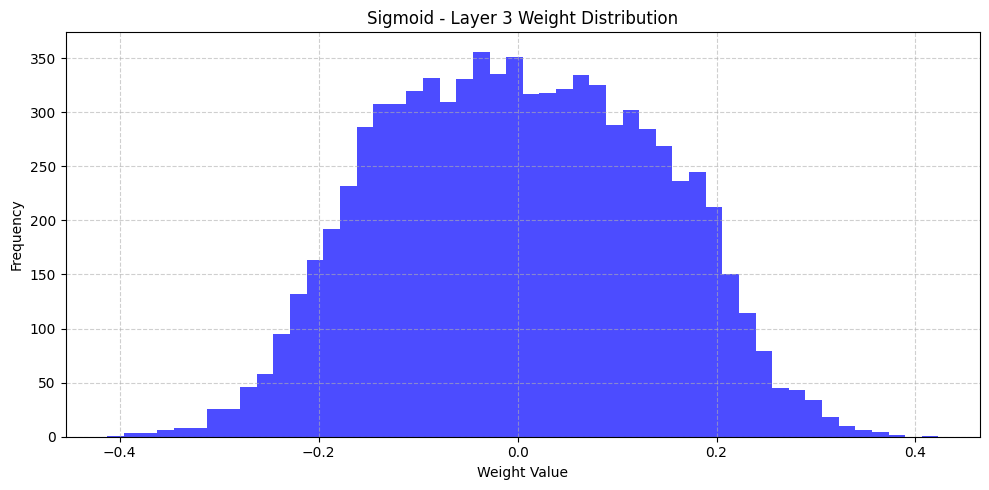

Weight stats for Sigmoid - Layer 3:
  Mean: 0.001103
  Std Dev: 0.134984
  Min: -0.412582
  Max: 0.423115


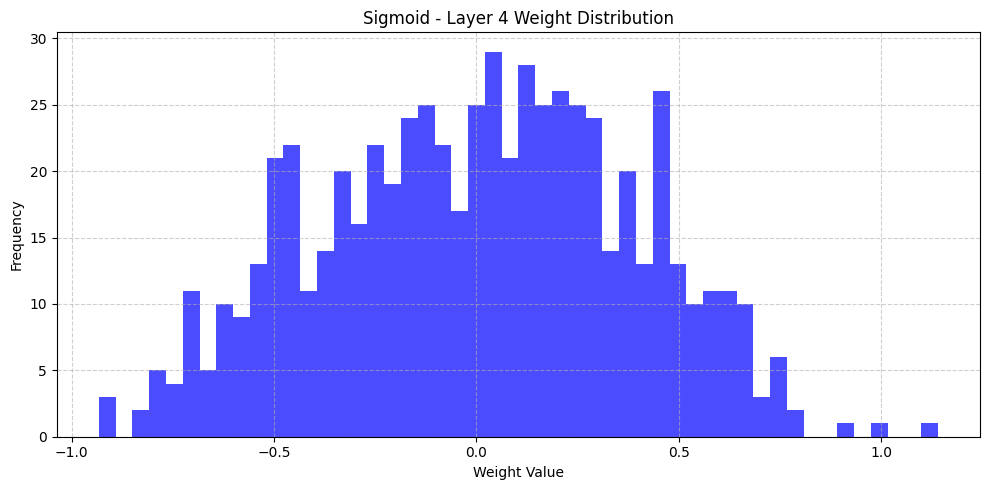

Weight stats for Sigmoid - Layer 4:
  Mean: -0.000814
  Std Dev: 0.381872
  Min: -0.932689
  Max: 1.140352
No gradient (dW) attribute found for layer 1
No gradient (dW) attribute found for layer 2
No gradient (dW) attribute found for layer 3
No gradient (dW) attribute found for layer 4

===== Activation Functions - Tanh =====


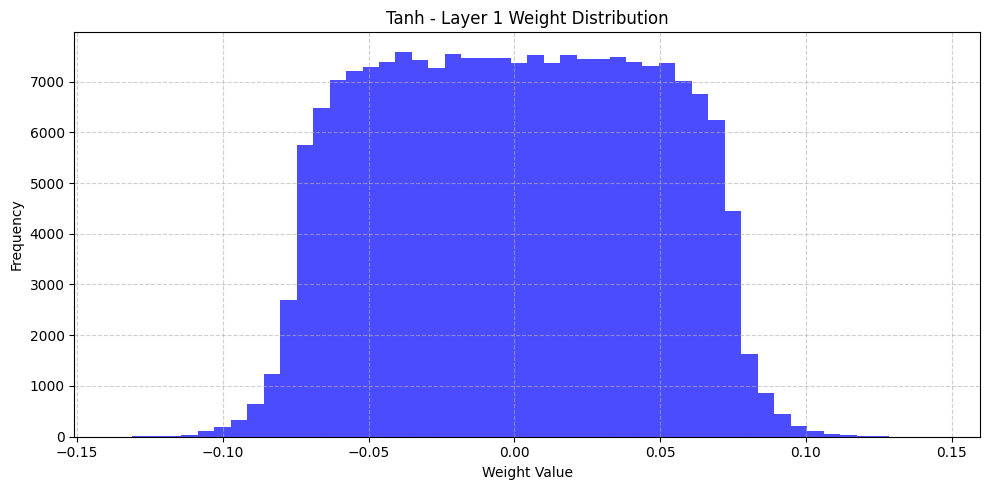

Weight stats for Tanh - Layer 1:
  Mean: 0.000003
  Std Dev: 0.045118
  Min: -0.136842
  Max: 0.145573


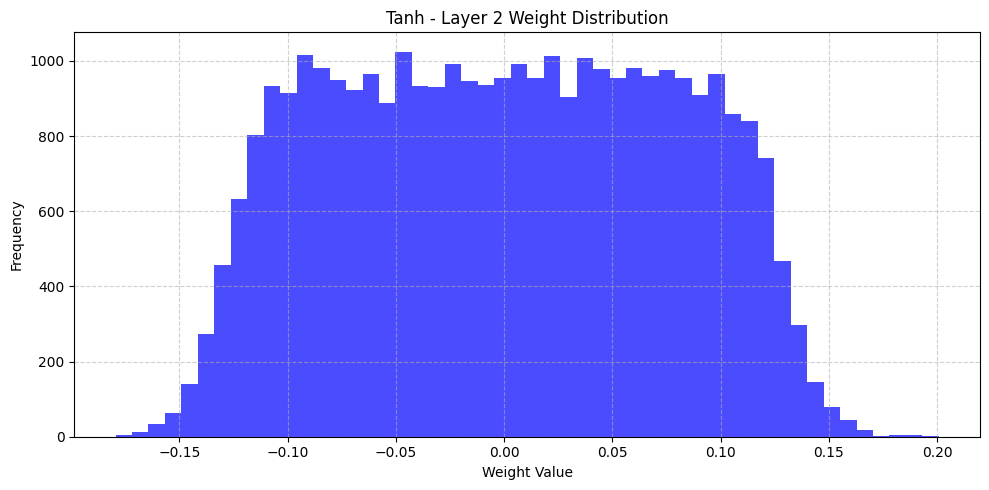

Weight stats for Tanh - Layer 2:
  Mean: 0.000063
  Std Dev: 0.076402
  Min: -0.179413
  Max: 0.200752


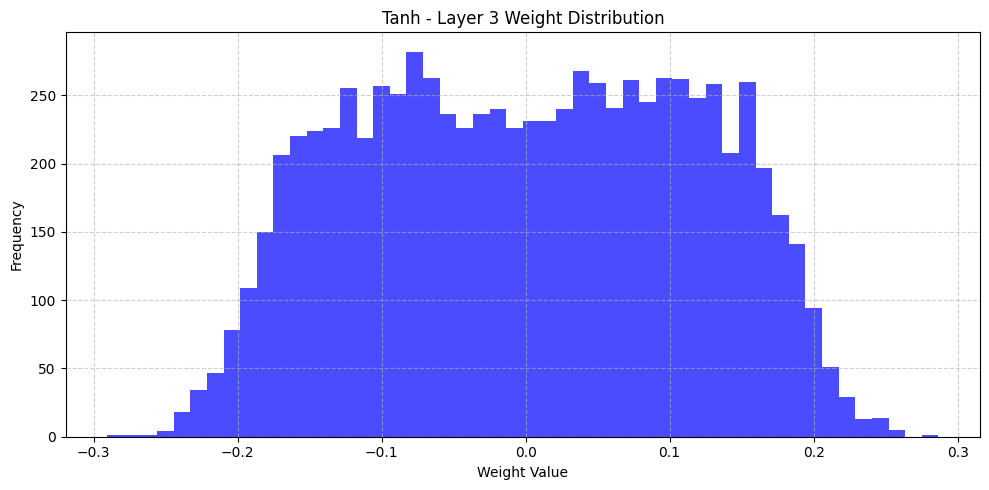

Weight stats for Tanh - Layer 3:
  Mean: 0.001039
  Std Dev: 0.114423
  Min: -0.290574
  Max: 0.286712


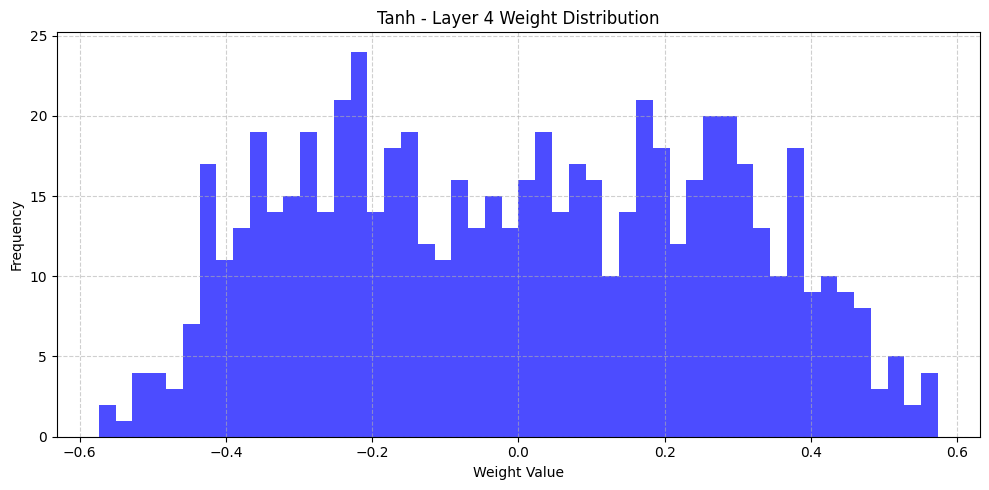

Weight stats for Tanh - Layer 4:
  Mean: -0.000750
  Std Dev: 0.274830
  Min: -0.573724
  Max: 0.573645
No gradient (dW) attribute found for layer 1
No gradient (dW) attribute found for layer 2
No gradient (dW) attribute found for layer 3
No gradient (dW) attribute found for layer 4

===== Activation Functions - ReLU =====


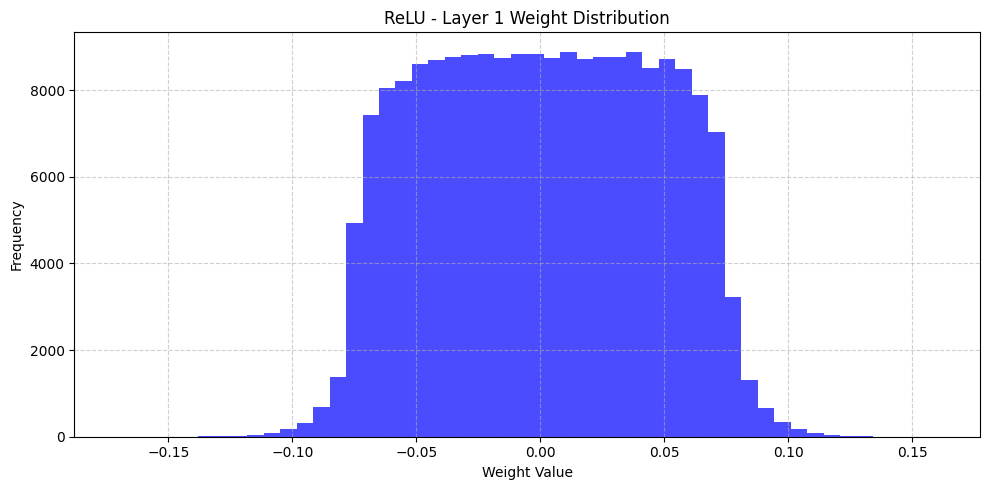

Weight stats for ReLU - Layer 1:
  Mean: 0.000520
  Std Dev: 0.045071
  Min: -0.171322
  Max: 0.160698


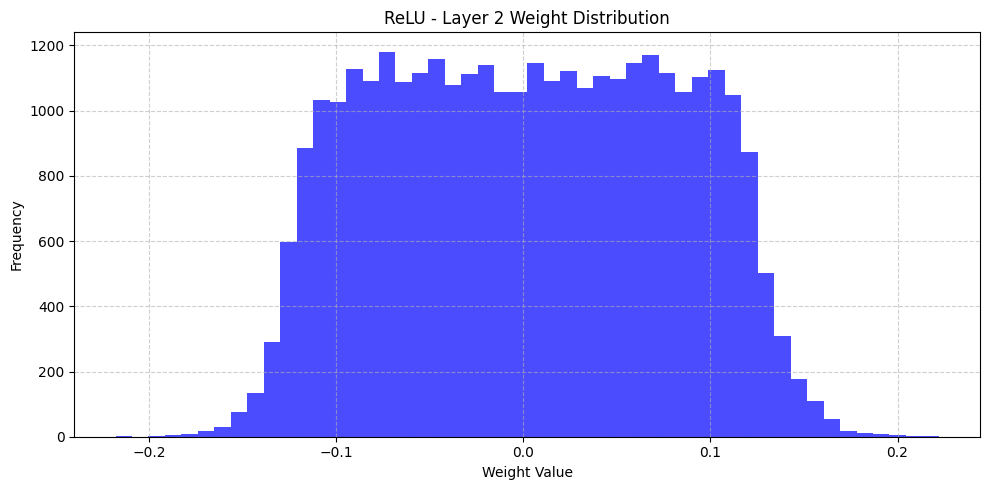

Weight stats for ReLU - Layer 2:
  Mean: 0.002444
  Std Dev: 0.076741
  Min: -0.218016
  Max: 0.222066


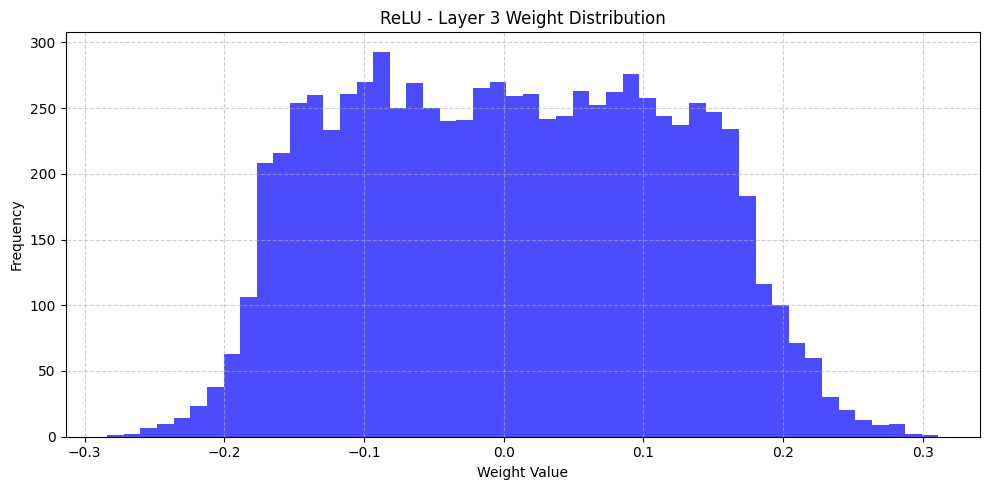

Weight stats for ReLU - Layer 3:
  Mean: 0.005424
  Std Dev: 0.113596
  Min: -0.283906
  Max: 0.311355


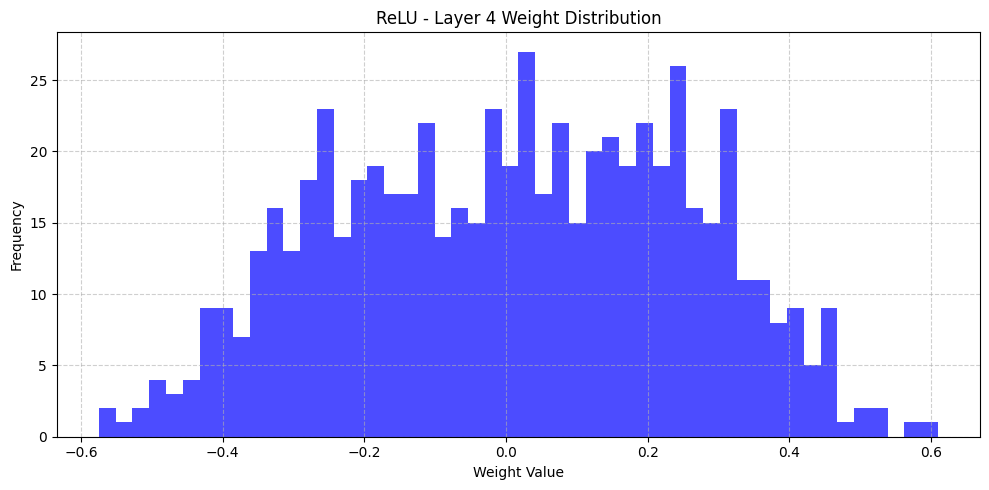

Weight stats for ReLU - Layer 4:
  Mean: 0.008077
  Std Dev: 0.244478
  Min: -0.574710
  Max: 0.610032
No gradient (dW) attribute found for layer 1
No gradient (dW) attribute found for layer 2
No gradient (dW) attribute found for layer 3
No gradient (dW) attribute found for layer 4

===== Activation Functions - Linear =====


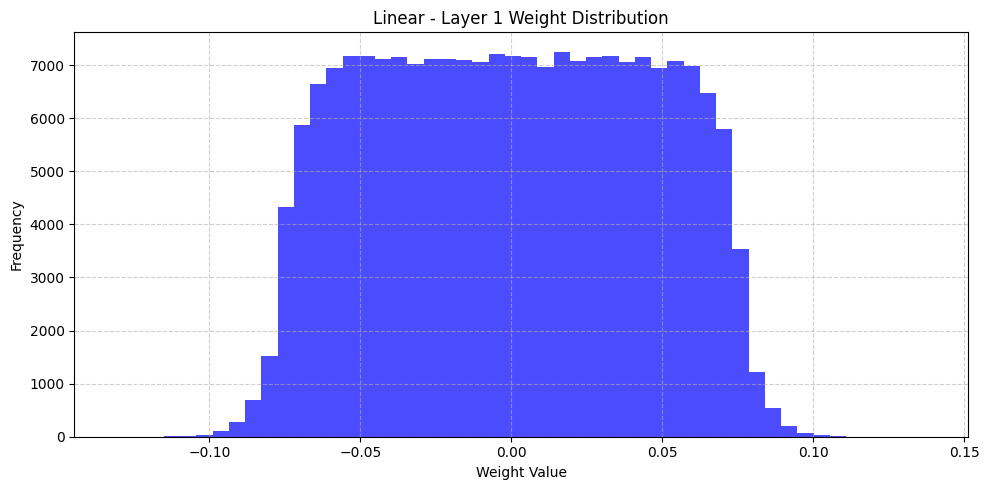

Weight stats for Linear - Layer 1:
  Mean: -0.000088
  Std Dev: 0.044486
  Min: -0.131290
  Max: 0.137861


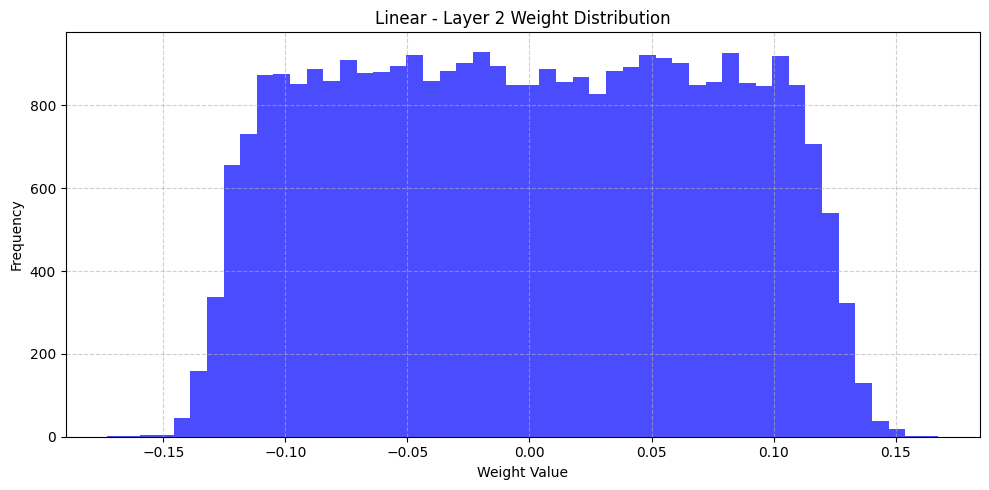

Weight stats for Linear - Layer 2:
  Mean: -0.000040
  Std Dev: 0.073689
  Min: -0.172969
  Max: 0.167530


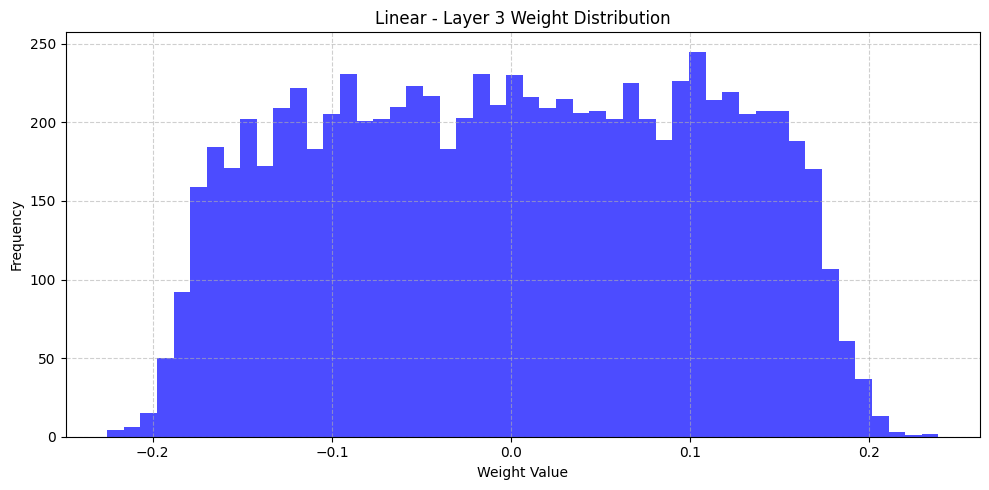

Weight stats for Linear - Layer 3:
  Mean: 0.001016
  Std Dev: 0.105390
  Min: -0.225410
  Max: 0.238583


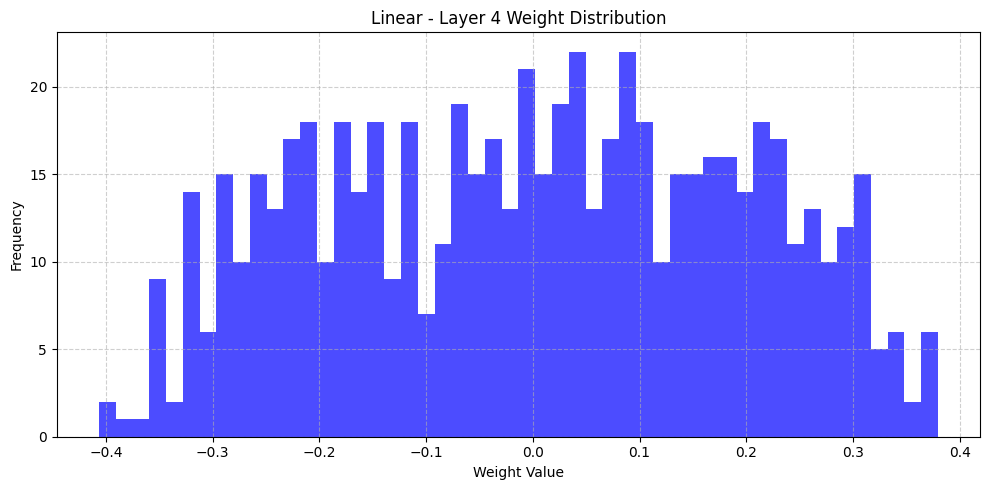

Weight stats for Linear - Layer 4:
  Mean: 0.002166
  Std Dev: 0.191213
  Min: -0.406615
  Max: 0.379646
No gradient (dW) attribute found for layer 1
No gradient (dW) attribute found for layer 2
No gradient (dW) attribute found for layer 3
No gradient (dW) attribute found for layer 4


In [9]:
# 2. Experiment: Activation Functions
print("\n===== EXPERIMENT: ACTIVATION FUNCTIONS =====")

# Test different activation functions for hidden layers
activation_configs = [
    {'activation': 'sigmoid', 'name': 'Sigmoid'},
    {'activation': 'tanh', 'name': 'Tanh'},
    {'activation': 'relu', 'name': 'ReLU'},
    {'activation': 'linear', 'name': 'Linear'}
]

activation_results = {}
for cfg in activation_configs:
    print(f"\nTraining model with {cfg['name']} activation...")
    modified_config = copy.deepcopy(base_config)
    # Apply this activation to all hidden layers, keep softmax for output
    hidden_layer_count = len(modified_config['model']['hidden_layers'])
    modified_config['model']['activations'] = [cfg['activation']] * hidden_layer_count + ['softmax']
    model, history, accs = train_and_evaluate(modified_config)
    activation_results[cfg['name']] = {'history': history, 'accs': accs, 'model': model}

plot_loss_histories(activation_results, "Activation Functions")
summarize_results(activation_results, 'Accuracy Comparison (Activation Functions)')
visualize_model_distributions(activation_results, "Activation Functions")


===== EXPERIMENT: LEARNING RATE =====

Training model with LR 0.001...


Epoch 1/10: 100%|██████████| 1500/1500 [00:04<00:00, 327.92it/s]


 - train_loss: 1.9907 - val_loss: 1.5672


Epoch 2/10: 100%|██████████| 1500/1500 [00:04<00:00, 313.17it/s]


 - train_loss: 1.1710 - val_loss: 0.8396


Epoch 3/10: 100%|██████████| 1500/1500 [00:04<00:00, 352.75it/s]


 - train_loss: 0.7040 - val_loss: 0.5812


Epoch 4/10: 100%|██████████| 1500/1500 [00:04<00:00, 345.57it/s]


 - train_loss: 0.5336 - val_loss: 0.4735


Epoch 5/10: 100%|██████████| 1500/1500 [00:04<00:00, 345.97it/s]


 - train_loss: 0.4538 - val_loss: 0.4157


Epoch 6/10: 100%|██████████| 1500/1500 [00:04<00:00, 306.04it/s]


 - train_loss: 0.4074 - val_loss: 0.3796


Epoch 7/10: 100%|██████████| 1500/1500 [00:04<00:00, 323.77it/s]


 - train_loss: 0.3765 - val_loss: 0.3549


Epoch 8/10: 100%|██████████| 1500/1500 [00:04<00:00, 333.31it/s]


 - train_loss: 0.3539 - val_loss: 0.3364


Epoch 9/10: 100%|██████████| 1500/1500 [00:04<00:00, 344.23it/s]


 - train_loss: 0.3365 - val_loss: 0.3218


Epoch 10/10: 100%|██████████| 1500/1500 [00:04<00:00, 337.60it/s]


 - train_loss: 0.3217 - val_loss: 0.3103

Training model with LR 0.01...


Epoch 1/10: 100%|██████████| 1500/1500 [00:04<00:00, 352.96it/s]


 - train_loss: 0.6774 - val_loss: 0.3214


Epoch 2/10: 100%|██████████| 1500/1500 [00:04<00:00, 346.94it/s]


 - train_loss: 0.2878 - val_loss: 0.2460


Epoch 3/10: 100%|██████████| 1500/1500 [00:04<00:00, 363.11it/s]


 - train_loss: 0.2285 - val_loss: 0.2103


Epoch 4/10: 100%|██████████| 1500/1500 [00:04<00:00, 302.70it/s]


 - train_loss: 0.1915 - val_loss: 0.1849


Epoch 5/10: 100%|██████████| 1500/1500 [00:05<00:00, 276.92it/s]


 - train_loss: 0.1642 - val_loss: 0.1633


Epoch 6/10: 100%|██████████| 1500/1500 [00:04<00:00, 316.79it/s]


 - train_loss: 0.1428 - val_loss: 0.1530


Epoch 7/10: 100%|██████████| 1500/1500 [00:04<00:00, 349.52it/s]


 - train_loss: 0.1260 - val_loss: 0.1365


Epoch 8/10: 100%|██████████| 1500/1500 [00:04<00:00, 333.06it/s]


 - train_loss: 0.1120 - val_loss: 0.1362


Epoch 9/10: 100%|██████████| 1500/1500 [00:04<00:00, 351.06it/s]


 - train_loss: 0.1000 - val_loss: 0.1223


Epoch 10/10: 100%|██████████| 1500/1500 [00:04<00:00, 358.21it/s]


 - train_loss: 0.0896 - val_loss: 0.1181

Training model with LR 0.1...


Epoch 1/10: 100%|██████████| 1500/1500 [00:04<00:00, 354.66it/s]


 - train_loss: 0.2863 - val_loss: 0.1319


Epoch 2/10: 100%|██████████| 1500/1500 [00:04<00:00, 344.02it/s]


 - train_loss: 0.1121 - val_loss: 0.1067


Epoch 3/10: 100%|██████████| 1500/1500 [00:04<00:00, 342.49it/s]


 - train_loss: 0.0741 - val_loss: 0.0926


Epoch 4/10: 100%|██████████| 1500/1500 [00:04<00:00, 349.95it/s]


 - train_loss: 0.0571 - val_loss: 0.0921


Epoch 5/10: 100%|██████████| 1500/1500 [00:04<00:00, 343.65it/s]


 - train_loss: 0.0406 - val_loss: 0.0799


Epoch 6/10: 100%|██████████| 1500/1500 [00:04<00:00, 336.35it/s]


 - train_loss: 0.0303 - val_loss: 0.0810


Epoch 7/10: 100%|██████████| 1500/1500 [00:04<00:00, 341.47it/s]


 - train_loss: 0.0244 - val_loss: 0.0876


Epoch 8/10: 100%|██████████| 1500/1500 [00:03<00:00, 377.97it/s]


 - train_loss: 0.0198 - val_loss: 0.0937


Epoch 9/10: 100%|██████████| 1500/1500 [00:04<00:00, 315.53it/s]


 - train_loss: 0.0136 - val_loss: 0.0914


Epoch 10/10: 100%|██████████| 1500/1500 [00:03<00:00, 382.97it/s]


 - train_loss: 0.0129 - val_loss: 0.0857


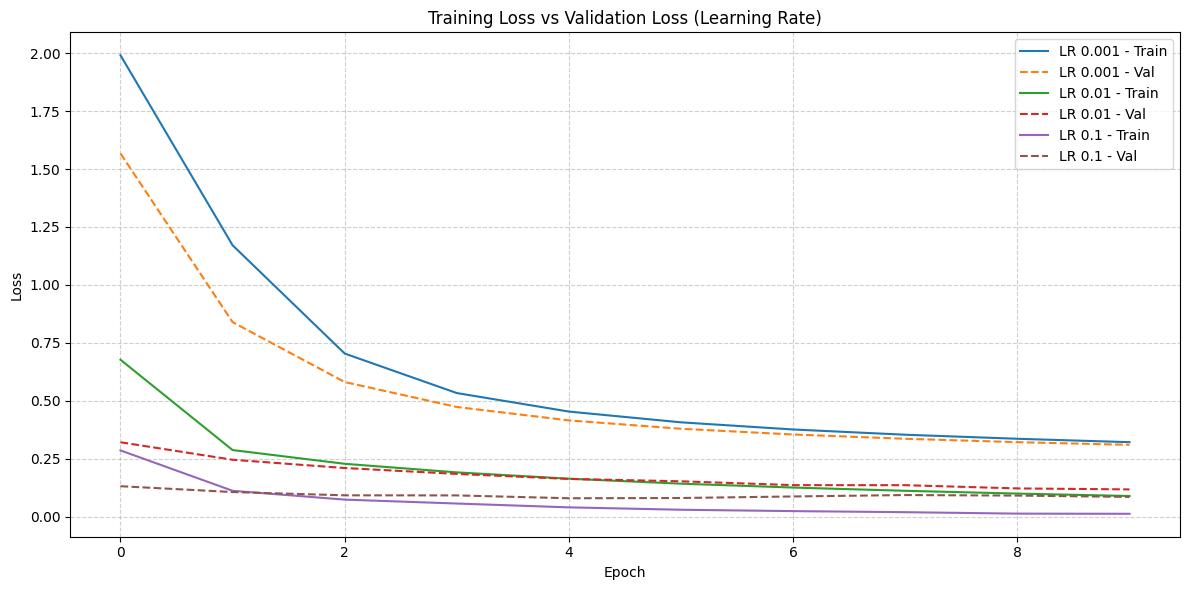

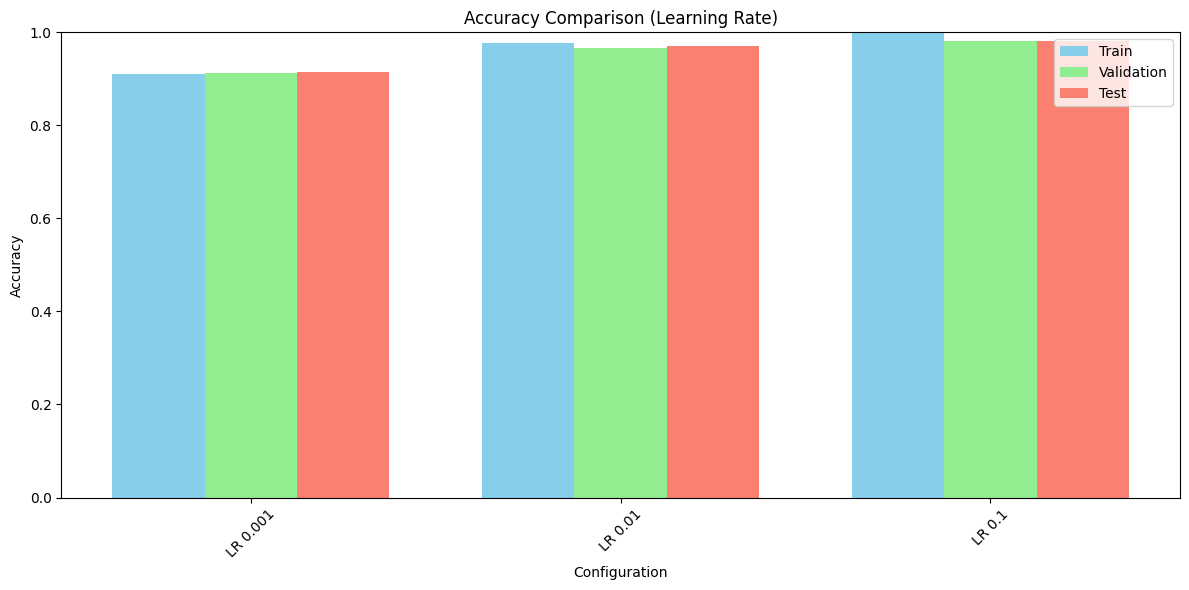


Detailed results:
Configuration        Train Acc  Val Acc    Test Acc  
--------------------------------------------------
LR 0.001             0.9112     0.9123     0.9140
LR 0.01              0.9777     0.9657     0.9696
LR 0.1               0.9983     0.9806     0.9812

===== Learning Rate - LR 0.001 =====


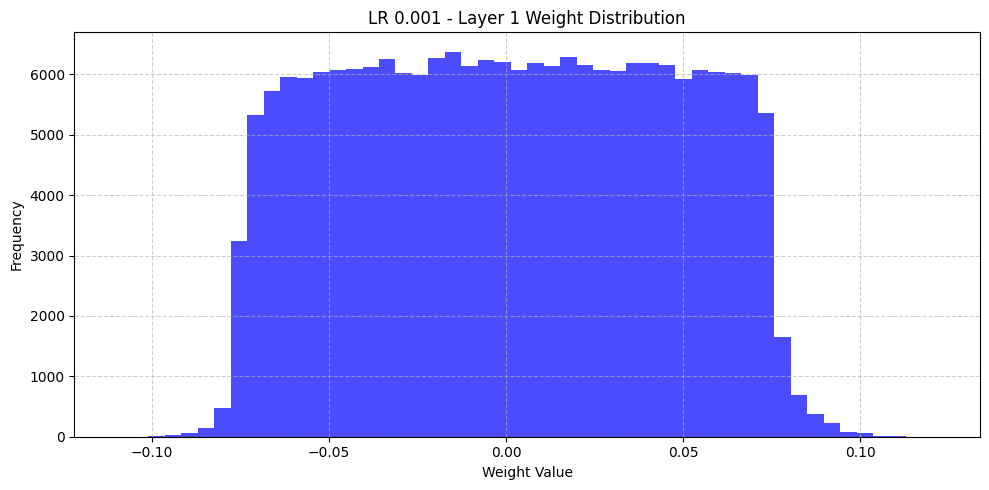

Weight stats for LR 0.001 - Layer 1:
  Mean: 0.001130
  Std Dev: 0.044198
  Min: -0.110301
  Max: 0.122138


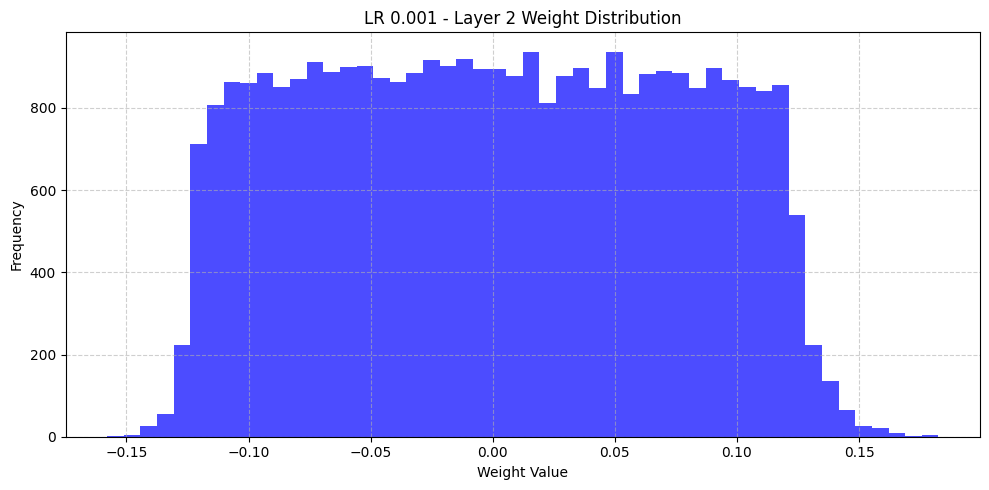

Weight stats for LR 0.001 - Layer 2:
  Mean: 0.002112
  Std Dev: 0.073350
  Min: -0.157868
  Max: 0.182483


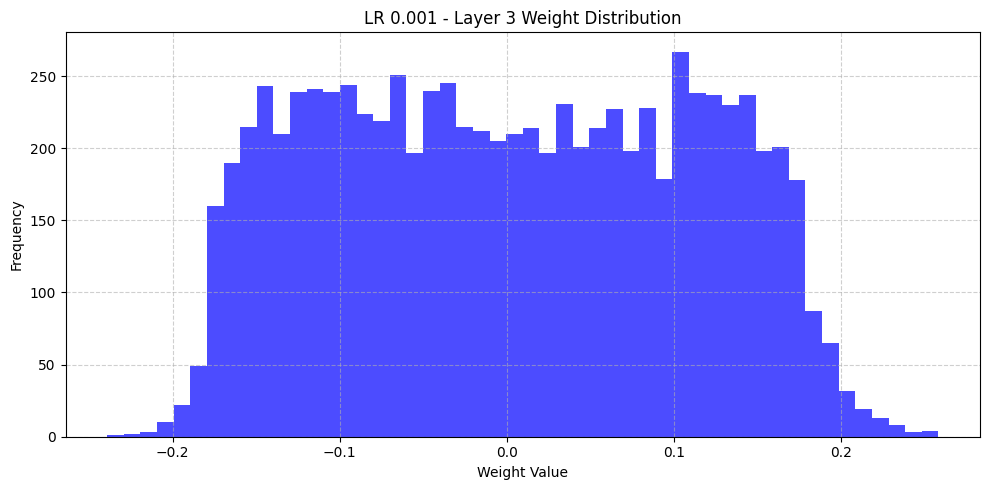

Weight stats for LR 0.001 - Layer 3:
  Mean: 0.002723
  Std Dev: 0.107275
  Min: -0.239092
  Max: 0.258357


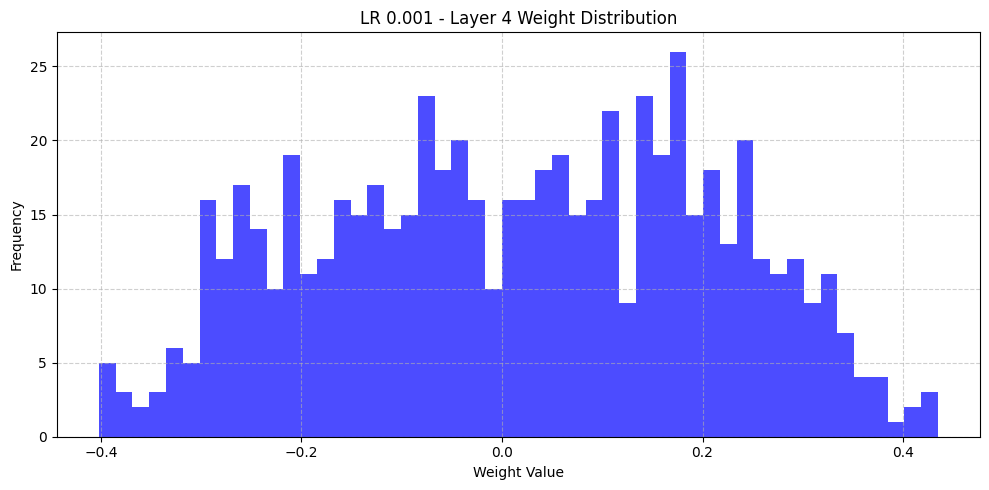

Weight stats for LR 0.001 - Layer 4:
  Mean: 0.014141
  Std Dev: 0.193880
  Min: -0.402002
  Max: 0.434867
No gradient (dW) attribute found for layer 1
No gradient (dW) attribute found for layer 2
No gradient (dW) attribute found for layer 3
No gradient (dW) attribute found for layer 4

===== Learning Rate - LR 0.01 =====


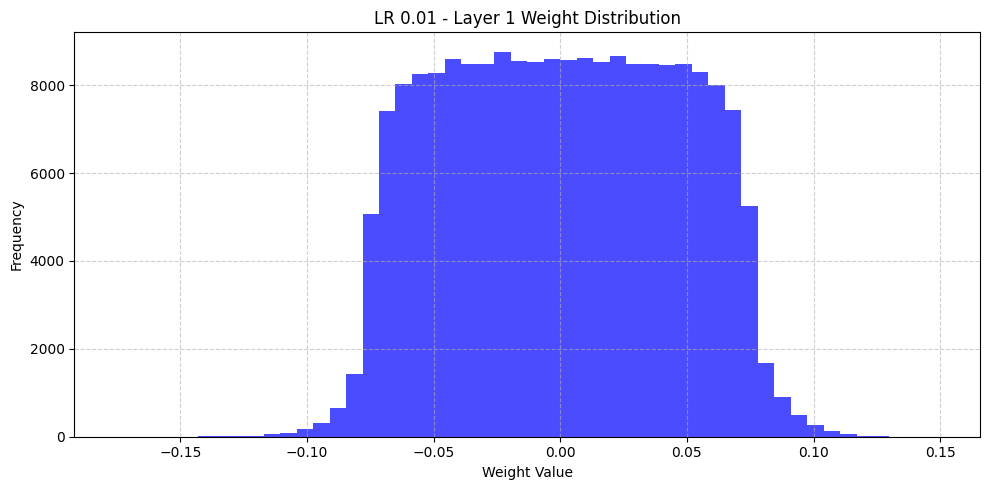

Weight stats for LR 0.01 - Layer 1:
  Mean: 0.000372
  Std Dev: 0.045168
  Min: -0.175564
  Max: 0.149445


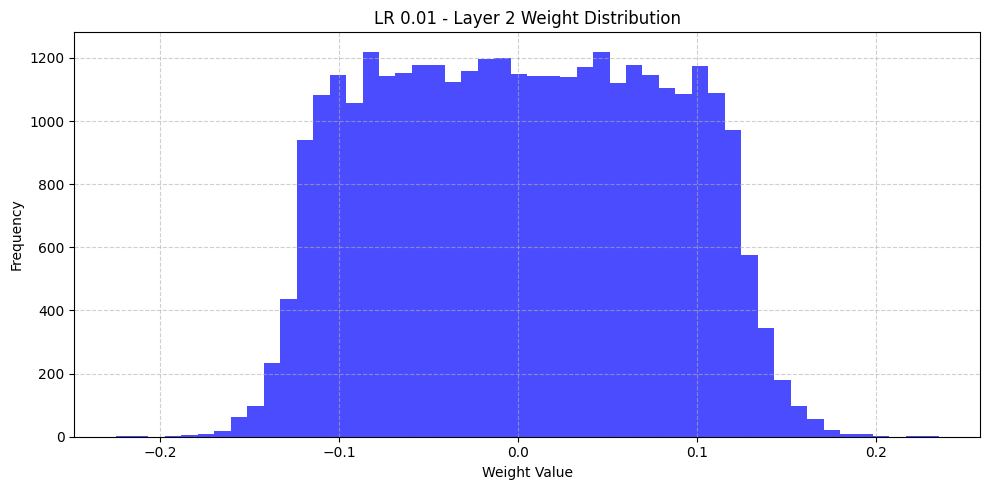

Weight stats for LR 0.01 - Layer 2:
  Mean: 0.002290
  Std Dev: 0.076738
  Min: -0.224970
  Max: 0.234914


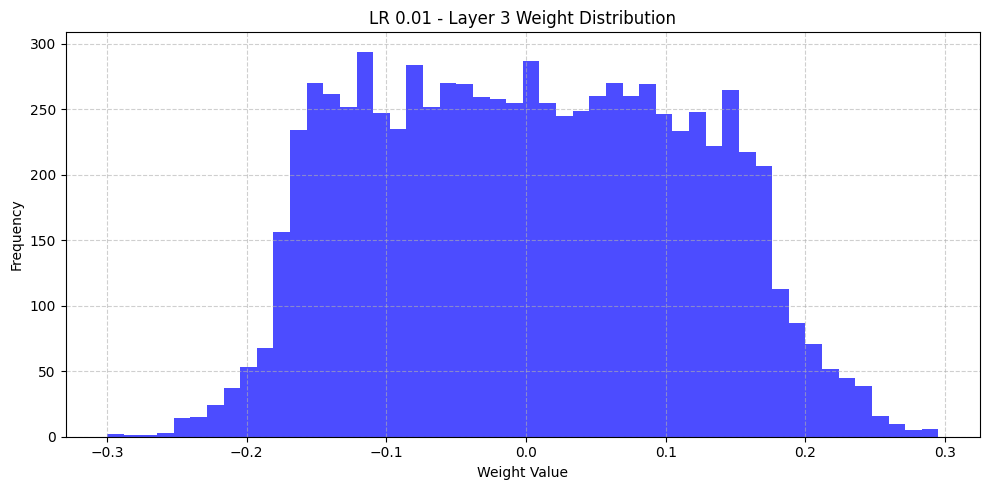

Weight stats for LR 0.01 - Layer 3:
  Mean: 0.002754
  Std Dev: 0.113044
  Min: -0.299877
  Max: 0.295193


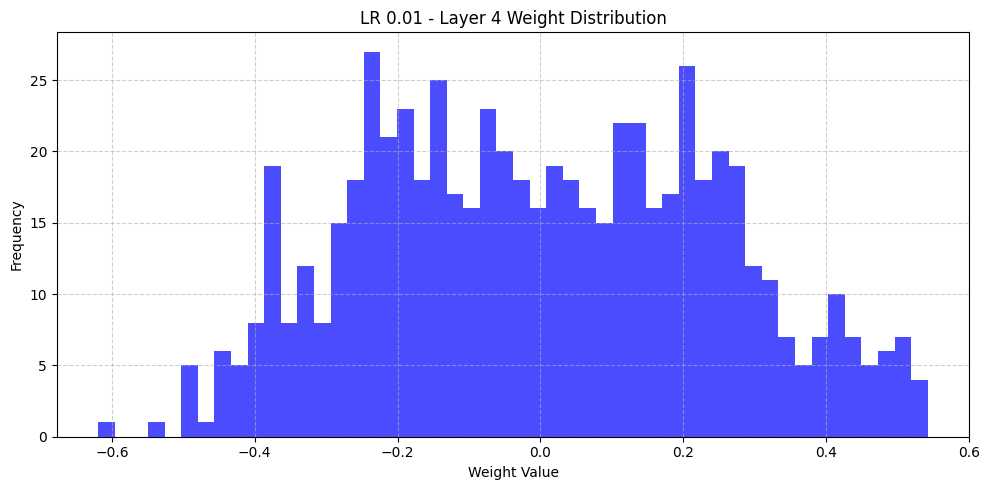

Weight stats for LR 0.01 - Layer 4:
  Mean: 0.001042
  Std Dev: 0.244878
  Min: -0.618884
  Max: 0.542185
No gradient (dW) attribute found for layer 1
No gradient (dW) attribute found for layer 2
No gradient (dW) attribute found for layer 3
No gradient (dW) attribute found for layer 4

===== Learning Rate - LR 0.1 =====


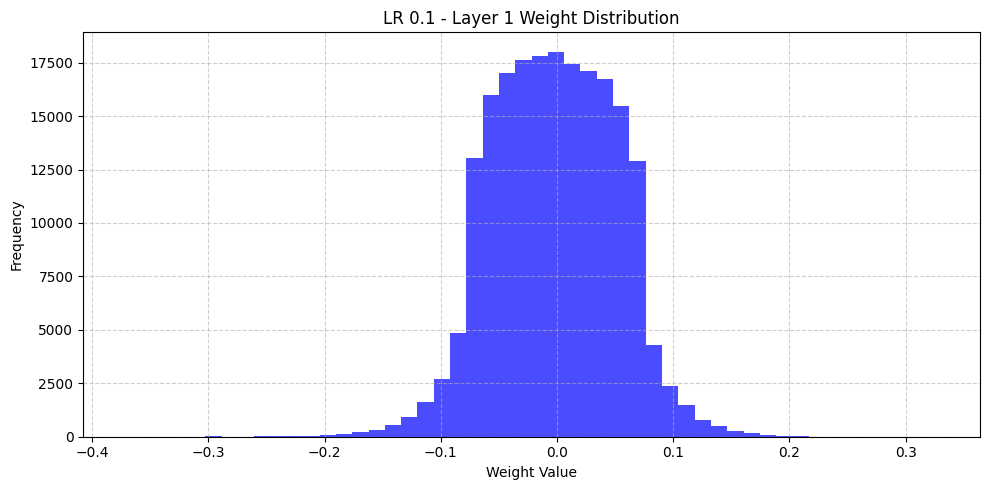

Weight stats for LR 0.1 - Layer 1:
  Mean: -0.002019
  Std Dev: 0.053248
  Min: -0.372651
  Max: 0.328961


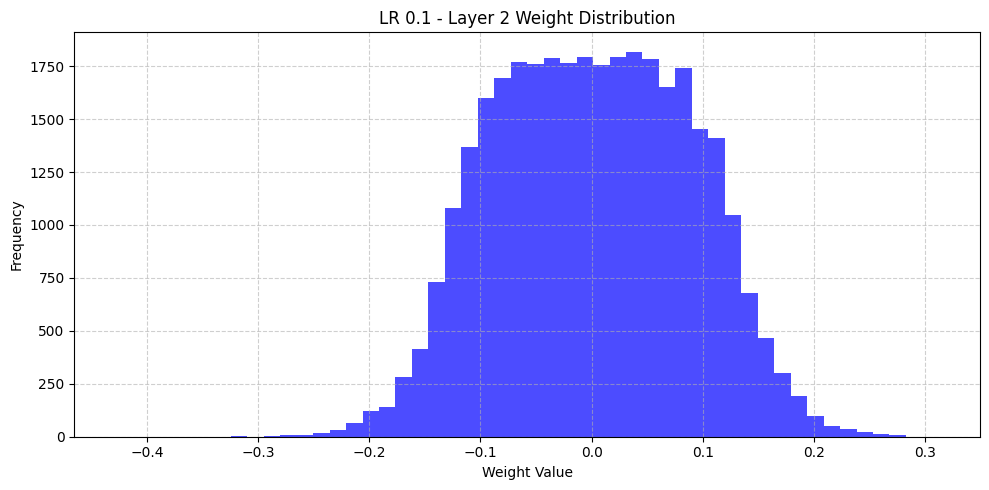

Weight stats for LR 0.1 - Layer 2:
  Mean: 0.001167
  Std Dev: 0.087493
  Min: -0.428402
  Max: 0.312541


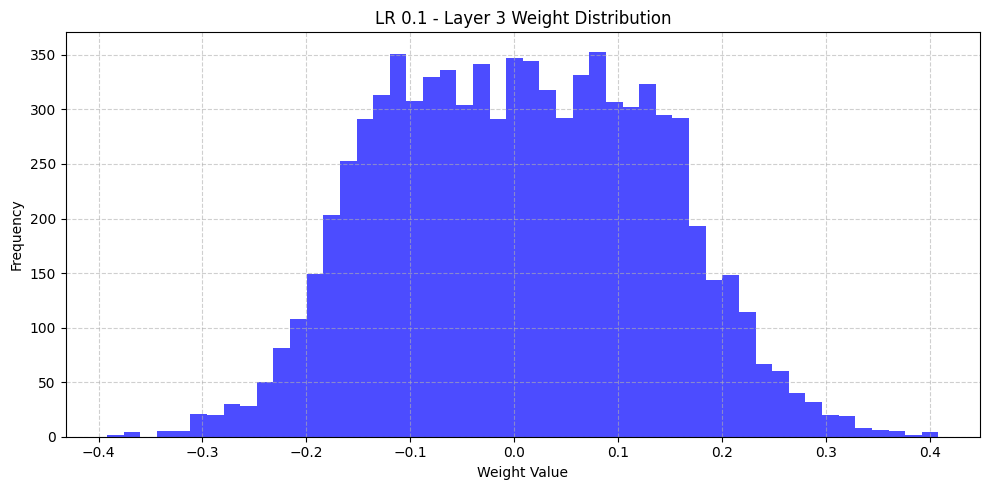

Weight stats for LR 0.1 - Layer 3:
  Mean: 0.005660
  Std Dev: 0.128885
  Min: -0.391652
  Max: 0.408149


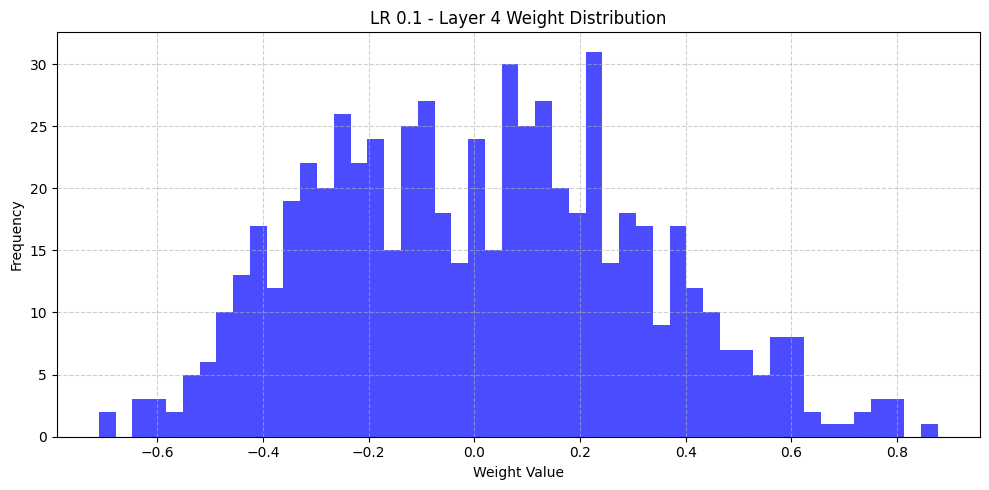

Weight stats for LR 0.1 - Layer 4:
  Mean: 0.010916
  Std Dev: 0.307078
  Min: -0.710584
  Max: 0.877644
No gradient (dW) attribute found for layer 1
No gradient (dW) attribute found for layer 2
No gradient (dW) attribute found for layer 3
No gradient (dW) attribute found for layer 4


In [10]:
# 3. Experiment: Learning Rate
print("\n===== EXPERIMENT: LEARNING RATE =====")

lr_configs = [
    {'lr': 0.001, 'name': 'LR 0.001'},
    {'lr': 0.01, 'name': 'LR 0.01'},
    {'lr': 0.1, 'name': 'LR 0.1'}
]

lr_results = {}
for cfg in lr_configs:
    print(f"\nTraining model with {cfg['name']}...")
    modified_config = copy.deepcopy(base_config)
    modified_config['training']['learning_rate'] = cfg['lr']
    model, history, accs = train_and_evaluate(modified_config)
    lr_results[cfg['name']] = {'history': history, 'accs': accs, 'model': model}

plot_loss_histories(lr_results, "Learning Rate")
summarize_results(lr_results, 'Accuracy Comparison (Learning Rate)')
visualize_model_distributions(lr_results, "Learning Rate")


===== EXPERIMENT: WEIGHT INITIALIZATION =====

Training model with Xavier initialization...


Epoch 1/10: 100%|██████████| 1500/1500 [00:03<00:00, 438.68it/s]


 - train_loss: 0.7054 - val_loss: 0.3198


Epoch 2/10: 100%|██████████| 1500/1500 [00:03<00:00, 399.88it/s]


 - train_loss: 0.2864 - val_loss: 0.2509


Epoch 3/10: 100%|██████████| 1500/1500 [00:03<00:00, 412.02it/s]


 - train_loss: 0.2270 - val_loss: 0.2066


Epoch 4/10: 100%|██████████| 1500/1500 [00:03<00:00, 422.15it/s]


 - train_loss: 0.1875 - val_loss: 0.1752


Epoch 5/10: 100%|██████████| 1500/1500 [00:03<00:00, 432.00it/s]


 - train_loss: 0.1597 - val_loss: 0.1566


Epoch 6/10: 100%|██████████| 1500/1500 [00:04<00:00, 338.53it/s]


 - train_loss: 0.1382 - val_loss: 0.1479


Epoch 7/10: 100%|██████████| 1500/1500 [00:04<00:00, 361.14it/s]


 - train_loss: 0.1218 - val_loss: 0.1280


Epoch 8/10: 100%|██████████| 1500/1500 [00:04<00:00, 328.88it/s]


 - train_loss: 0.1074 - val_loss: 0.1230


Epoch 9/10: 100%|██████████| 1500/1500 [00:04<00:00, 341.71it/s]


 - train_loss: 0.0966 - val_loss: 0.1156


Epoch 10/10: 100%|██████████| 1500/1500 [00:04<00:00, 336.63it/s]


 - train_loss: 0.0867 - val_loss: 0.1099

Training model with Zero initialization...


Epoch 1/10: 100%|██████████| 1500/1500 [00:03<00:00, 470.91it/s]


 - train_loss: 2.3018 - val_loss: 2.3010


Epoch 2/10: 100%|██████████| 1500/1500 [00:03<00:00, 481.02it/s]


 - train_loss: 2.3014 - val_loss: 2.3009


Epoch 3/10: 100%|██████████| 1500/1500 [00:03<00:00, 460.71it/s]


 - train_loss: 2.3014 - val_loss: 2.3008


Epoch 4/10: 100%|██████████| 1500/1500 [00:03<00:00, 398.48it/s]


 - train_loss: 2.3014 - val_loss: 2.3008


Epoch 5/10: 100%|██████████| 1500/1500 [00:04<00:00, 334.88it/s]


 - train_loss: 2.3014 - val_loss: 2.3009


Epoch 6/10: 100%|██████████| 1500/1500 [00:04<00:00, 328.80it/s]


 - train_loss: 2.3014 - val_loss: 2.3009


Epoch 7/10: 100%|██████████| 1500/1500 [00:04<00:00, 332.77it/s]


 - train_loss: 2.3014 - val_loss: 2.3008


Epoch 8/10: 100%|██████████| 1500/1500 [00:04<00:00, 307.98it/s]


 - train_loss: 2.3014 - val_loss: 2.3008


Epoch 9/10: 100%|██████████| 1500/1500 [00:04<00:00, 349.96it/s]


 - train_loss: 2.3014 - val_loss: 2.3008


Epoch 10/10: 100%|██████████| 1500/1500 [00:04<00:00, 338.70it/s]


 - train_loss: 2.3014 - val_loss: 2.3008

Training model with Uniform initialization...


Epoch 1/10: 100%|██████████| 1500/1500 [00:04<00:00, 338.40it/s]


 - train_loss: 1.3348 - val_loss: 0.4909


Epoch 2/10: 100%|██████████| 1500/1500 [00:04<00:00, 323.37it/s]


 - train_loss: 0.3916 - val_loss: 0.3225


Epoch 3/10: 100%|██████████| 1500/1500 [00:04<00:00, 343.28it/s]


 - train_loss: 0.2974 - val_loss: 0.2611


Epoch 4/10: 100%|██████████| 1500/1500 [00:03<00:00, 404.66it/s]


 - train_loss: 0.2440 - val_loss: 0.2226


Epoch 5/10: 100%|██████████| 1500/1500 [00:03<00:00, 415.62it/s]


 - train_loss: 0.2063 - val_loss: 0.1933


Epoch 6/10: 100%|██████████| 1500/1500 [00:03<00:00, 401.58it/s]


 - train_loss: 0.1770 - val_loss: 0.1738


Epoch 7/10: 100%|██████████| 1500/1500 [00:03<00:00, 418.97it/s]


 - train_loss: 0.1557 - val_loss: 0.1645


Epoch 8/10: 100%|██████████| 1500/1500 [00:04<00:00, 373.30it/s]


 - train_loss: 0.1382 - val_loss: 0.1468


Epoch 9/10: 100%|██████████| 1500/1500 [00:04<00:00, 371.05it/s]


 - train_loss: 0.1228 - val_loss: 0.1372


Epoch 10/10: 100%|██████████| 1500/1500 [00:04<00:00, 372.22it/s]


 - train_loss: 0.1116 - val_loss: 0.1304

Training model with He initialization...


Epoch 1/10: 100%|██████████| 1500/1500 [00:03<00:00, 389.75it/s]


 - train_loss: 0.5932 - val_loss: 0.2851


Epoch 2/10: 100%|██████████| 1500/1500 [00:04<00:00, 322.00it/s]


 - train_loss: 0.2513 - val_loss: 0.2148


Epoch 3/10: 100%|██████████| 1500/1500 [00:04<00:00, 321.54it/s]


 - train_loss: 0.1983 - val_loss: 0.1849


Epoch 4/10: 100%|██████████| 1500/1500 [00:04<00:00, 342.96it/s]


 - train_loss: 0.1646 - val_loss: 0.1601


Epoch 5/10: 100%|██████████| 1500/1500 [00:04<00:00, 353.25it/s]


 - train_loss: 0.1406 - val_loss: 0.1432


Epoch 6/10: 100%|██████████| 1500/1500 [00:04<00:00, 344.04it/s]


 - train_loss: 0.1221 - val_loss: 0.1359


Epoch 7/10: 100%|██████████| 1500/1500 [00:04<00:00, 352.72it/s]


 - train_loss: 0.1070 - val_loss: 0.1270


Epoch 8/10: 100%|██████████| 1500/1500 [00:04<00:00, 353.16it/s]


 - train_loss: 0.0937 - val_loss: 0.1217


Epoch 9/10: 100%|██████████| 1500/1500 [00:04<00:00, 321.16it/s]


 - train_loss: 0.0837 - val_loss: 0.1086


Epoch 10/10: 100%|██████████| 1500/1500 [00:04<00:00, 331.18it/s]


 - train_loss: 0.0752 - val_loss: 0.1111

Training model with Normal initialization...


Epoch 1/10: 100%|██████████| 1500/1500 [00:04<00:00, 336.44it/s]


 - train_loss: 1.0997 - val_loss: 0.5464


Epoch 2/10: 100%|██████████| 1500/1500 [00:04<00:00, 356.22it/s]


 - train_loss: 0.4692 - val_loss: 0.4027


Epoch 3/10: 100%|██████████| 1500/1500 [00:04<00:00, 329.04it/s]


 - train_loss: 0.3729 - val_loss: 0.3524


Epoch 4/10: 100%|██████████| 1500/1500 [00:04<00:00, 340.85it/s]


 - train_loss: 0.3184 - val_loss: 0.3238


Epoch 5/10: 100%|██████████| 1500/1500 [00:04<00:00, 316.80it/s]


 - train_loss: 0.2833 - val_loss: 0.2916


Epoch 6/10: 100%|██████████| 1500/1500 [00:04<00:00, 326.92it/s]


 - train_loss: 0.2538 - val_loss: 0.2777


Epoch 7/10: 100%|██████████| 1500/1500 [00:04<00:00, 330.19it/s]


 - train_loss: 0.2336 - val_loss: 0.2618


Epoch 8/10: 100%|██████████| 1500/1500 [00:04<00:00, 313.37it/s]


 - train_loss: 0.2154 - val_loss: 0.2528


Epoch 9/10: 100%|██████████| 1500/1500 [00:04<00:00, 341.13it/s]


 - train_loss: 0.2008 - val_loss: 0.2433


Epoch 10/10: 100%|██████████| 1500/1500 [00:04<00:00, 347.02it/s]


 - train_loss: 0.1866 - val_loss: 0.2407


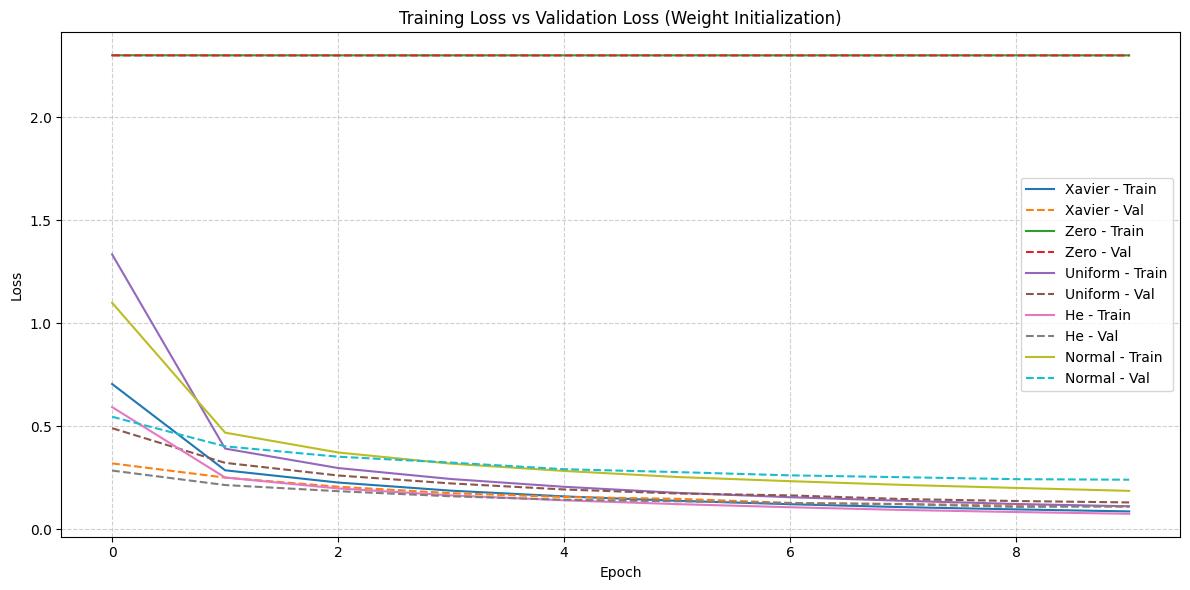

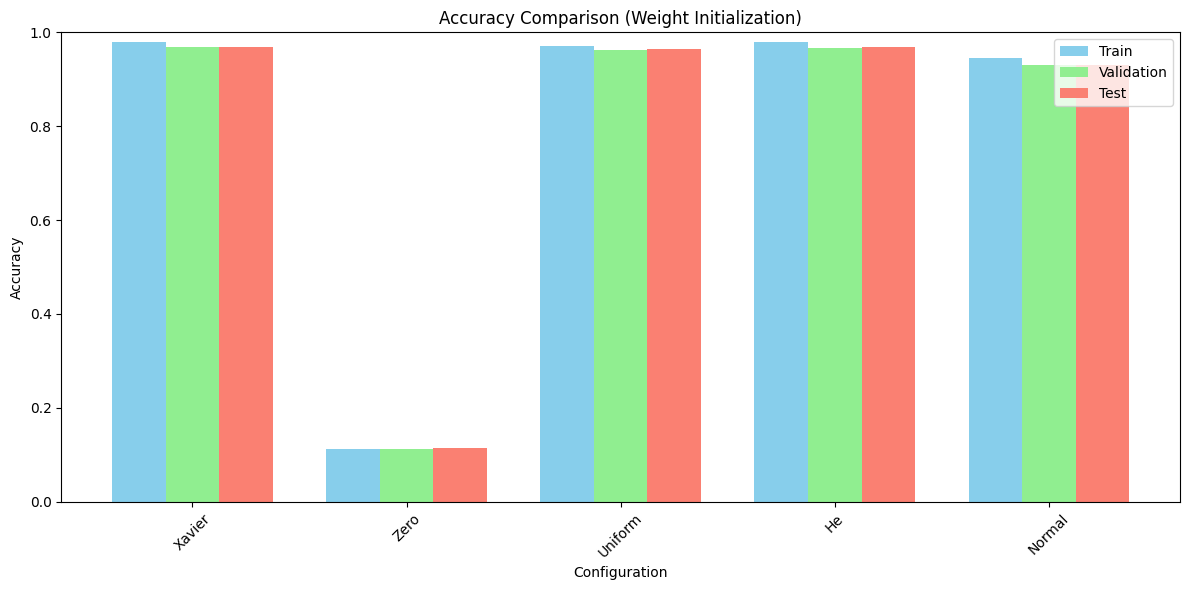


Detailed results:
Configuration        Train Acc  Val Acc    Test Acc  
--------------------------------------------------
Xavier               0.9788     0.9691     0.9680
Zero                 0.1123     0.1126     0.1135
Uniform              0.9716     0.9613     0.9638
He                   0.9804     0.9662     0.9683
Normal               0.9462     0.9294     0.9308

===== Weight Initialization - Xavier =====


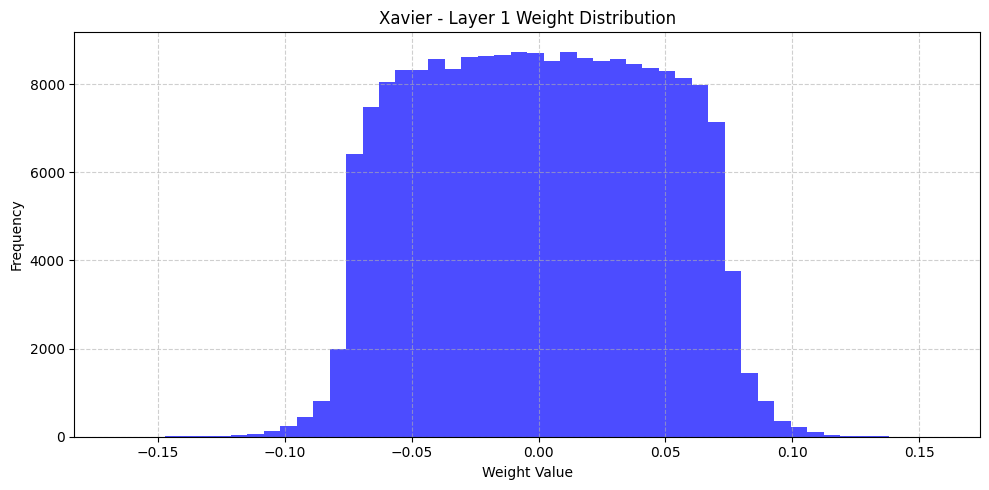

Weight stats for Xavier - Layer 1:
  Mean: 0.000465
  Std Dev: 0.045097
  Min: -0.166667
  Max: 0.157738


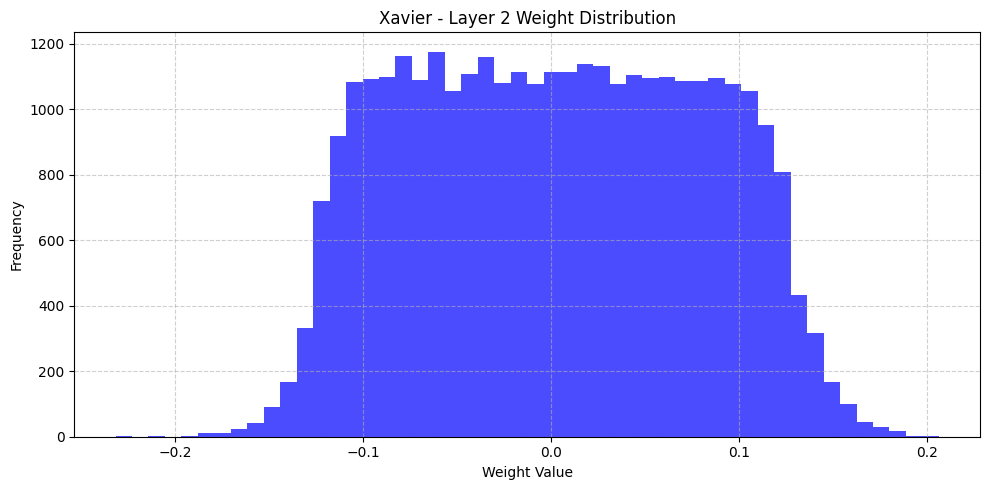

Weight stats for Xavier - Layer 2:
  Mean: 0.002436
  Std Dev: 0.076664
  Min: -0.231718
  Max: 0.206428


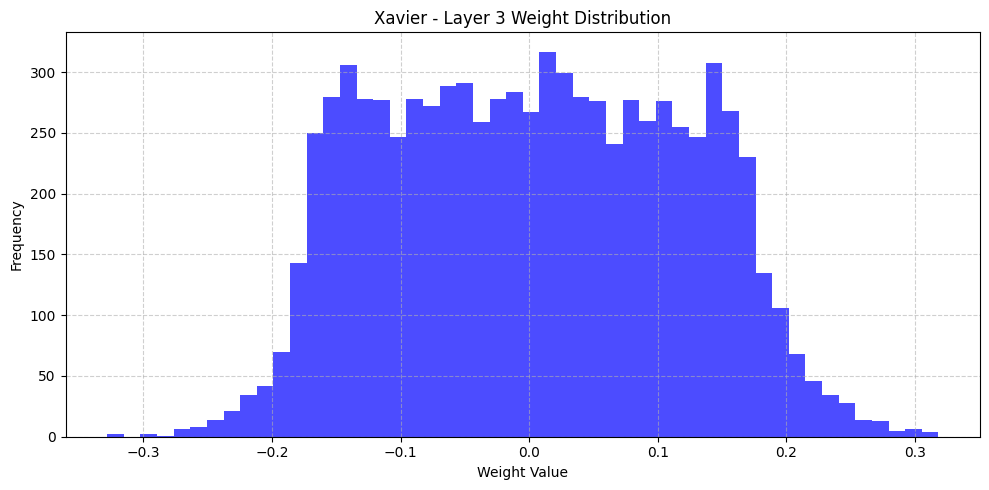

Weight stats for Xavier - Layer 3:
  Mean: 0.003306
  Std Dev: 0.114756
  Min: -0.328183
  Max: 0.318191


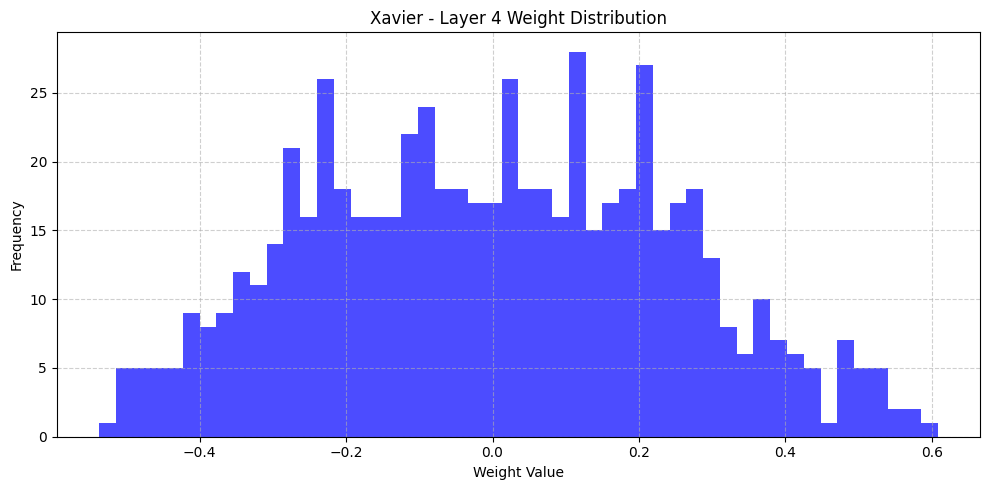

Weight stats for Xavier - Layer 4:
  Mean: -0.000656
  Std Dev: 0.245462
  Min: -0.537576
  Max: 0.608303
No gradient (dW) attribute found for layer 1
No gradient (dW) attribute found for layer 2
No gradient (dW) attribute found for layer 3
No gradient (dW) attribute found for layer 4

===== Weight Initialization - Zero =====


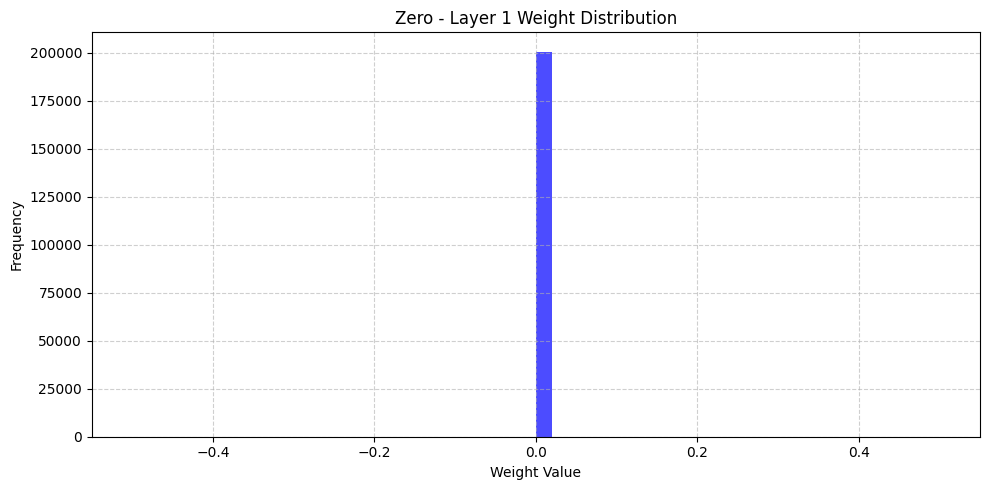

Weight stats for Zero - Layer 1:
  Mean: 0.000000
  Std Dev: 0.000000
  Min: 0.000000
  Max: 0.000000


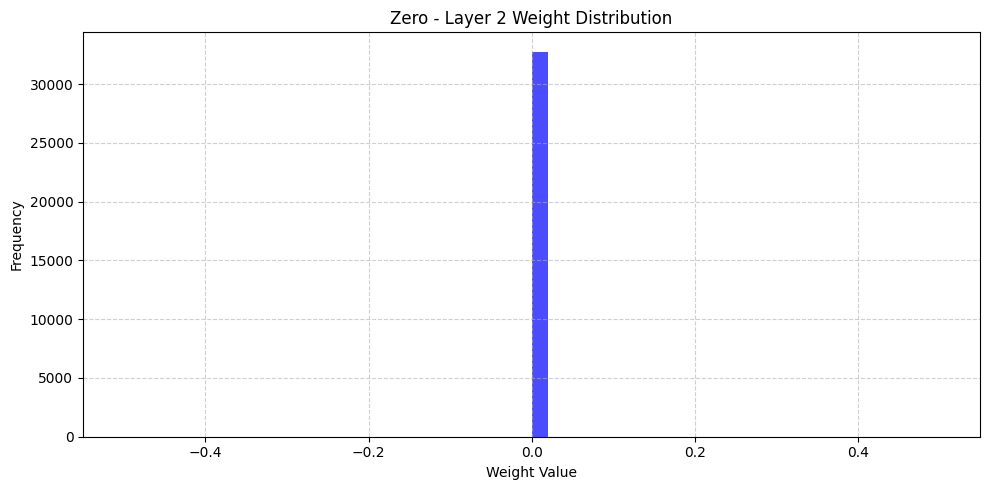

Weight stats for Zero - Layer 2:
  Mean: 0.000000
  Std Dev: 0.000000
  Min: 0.000000
  Max: 0.000000


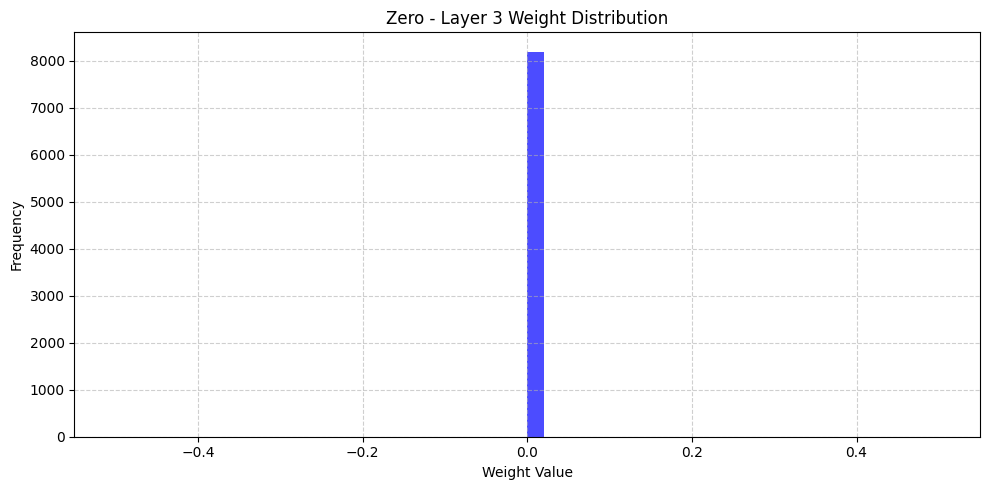

Weight stats for Zero - Layer 3:
  Mean: 0.000000
  Std Dev: 0.000000
  Min: 0.000000
  Max: 0.000000


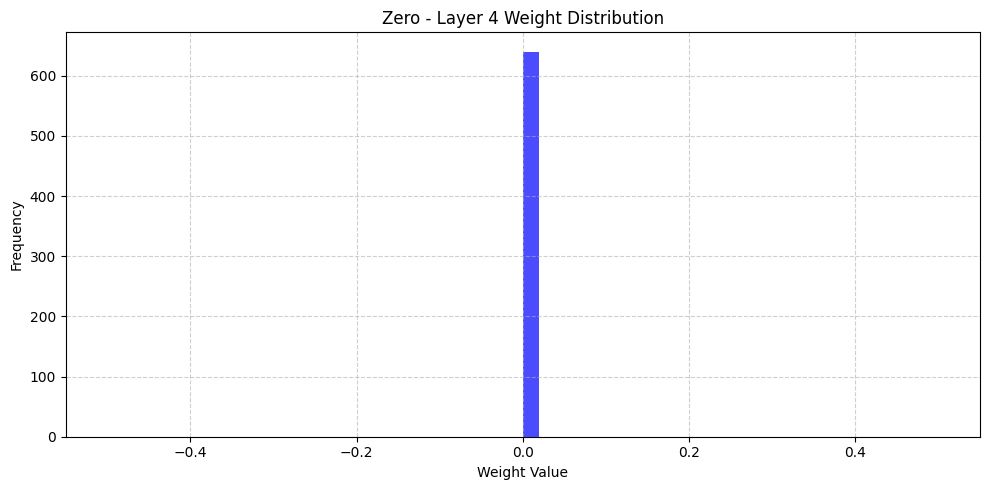

Weight stats for Zero - Layer 4:
  Mean: 0.000000
  Std Dev: 0.000000
  Min: 0.000000
  Max: 0.000000
No gradient (dW) attribute found for layer 1
No gradient (dW) attribute found for layer 2
No gradient (dW) attribute found for layer 3
No gradient (dW) attribute found for layer 4

===== Weight Initialization - Uniform =====


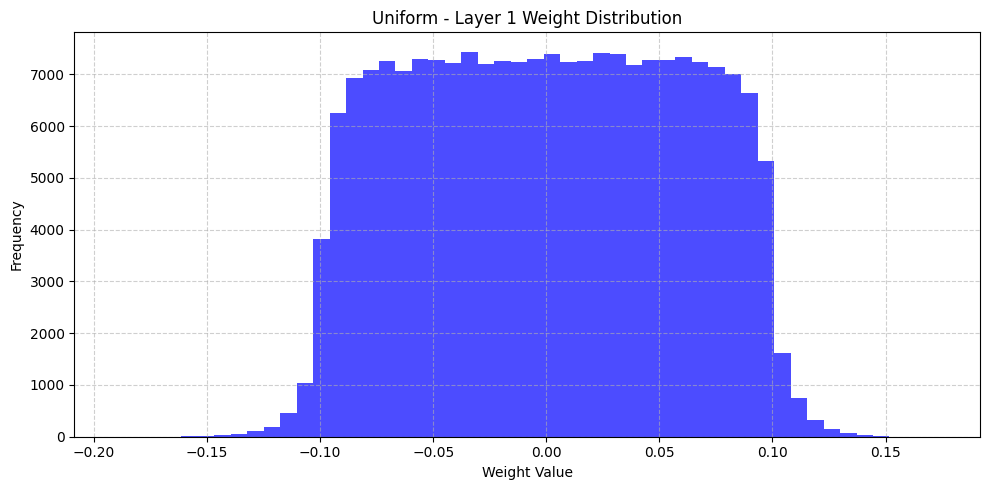

Weight stats for Uniform - Layer 1:
  Mean: 0.000495
  Std Dev: 0.058696
  Min: -0.190449
  Max: 0.173567


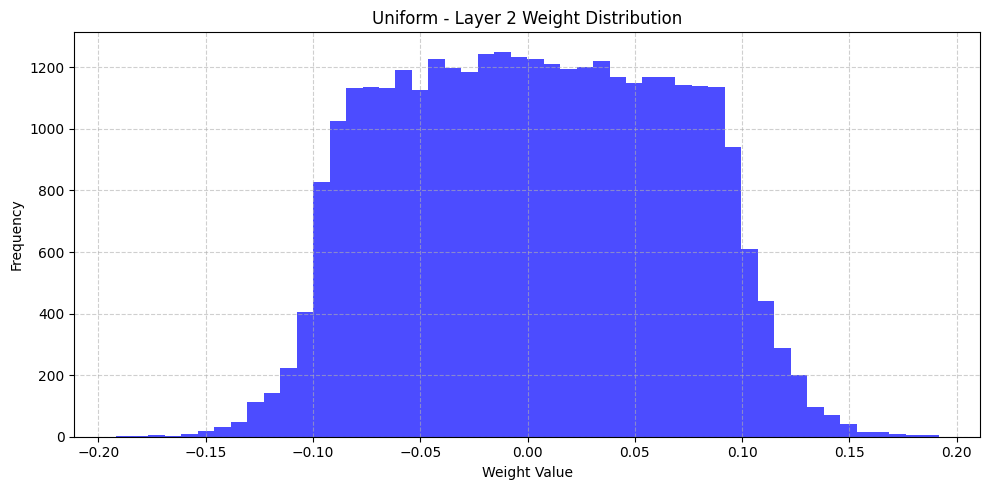

Weight stats for Uniform - Layer 2:
  Mean: 0.003318
  Std Dev: 0.063189
  Min: -0.192000
  Max: 0.191649


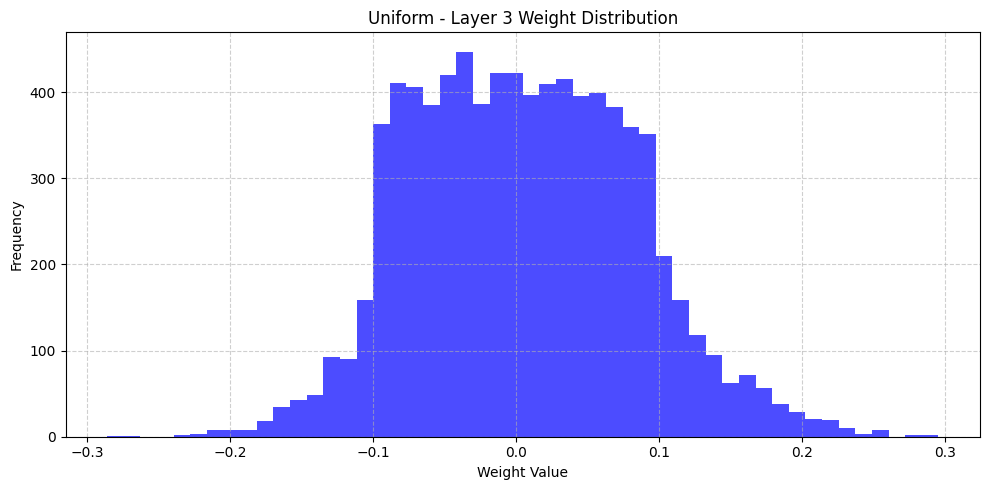

Weight stats for Uniform - Layer 3:
  Mean: 0.005314
  Std Dev: 0.077379
  Min: -0.285901
  Max: 0.295514


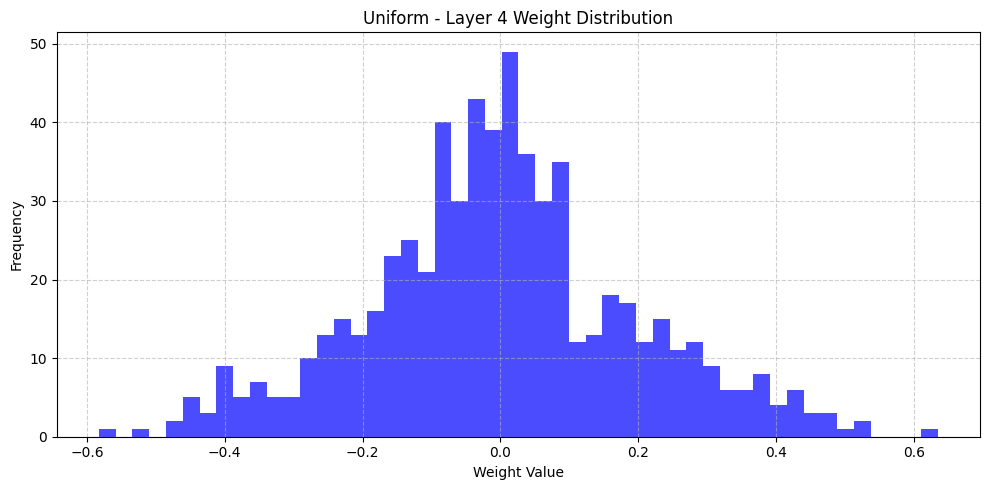

Weight stats for Uniform - Layer 4:
  Mean: -0.000478
  Std Dev: 0.194260
  Min: -0.582673
  Max: 0.635104
No gradient (dW) attribute found for layer 1
No gradient (dW) attribute found for layer 2
No gradient (dW) attribute found for layer 3
No gradient (dW) attribute found for layer 4

===== Weight Initialization - He =====


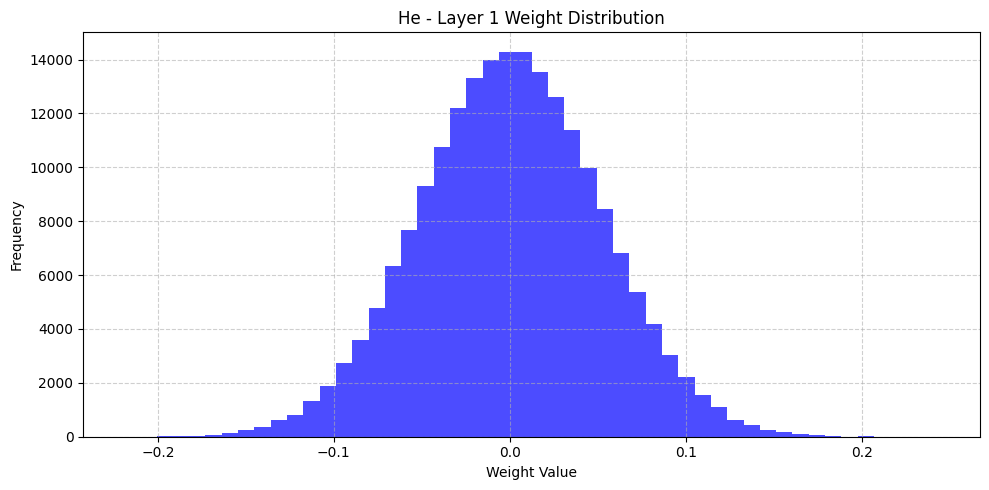

Weight stats for He - Layer 1:
  Mean: 0.000460
  Std Dev: 0.051660
  Min: -0.219266
  Max: 0.244090


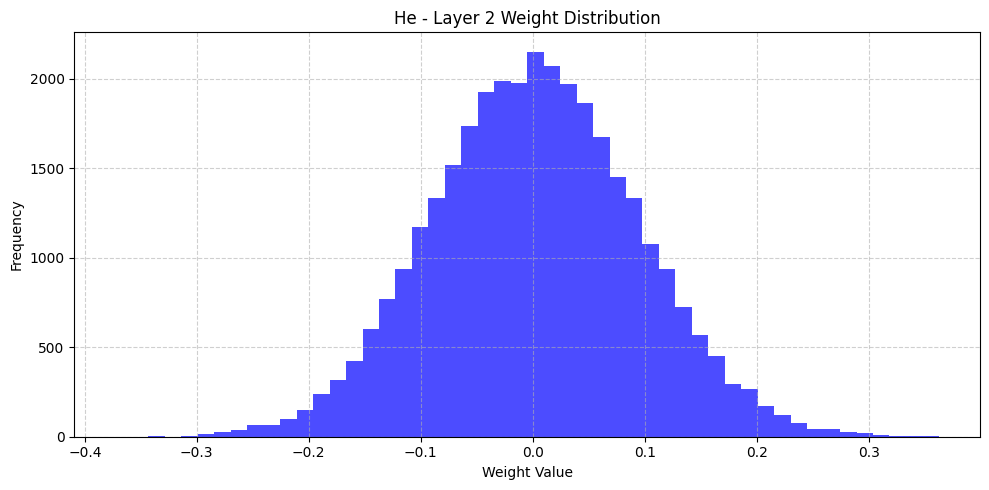

Weight stats for He - Layer 2:
  Mean: 0.001995
  Std Dev: 0.091947
  Min: -0.372525
  Max: 0.362721


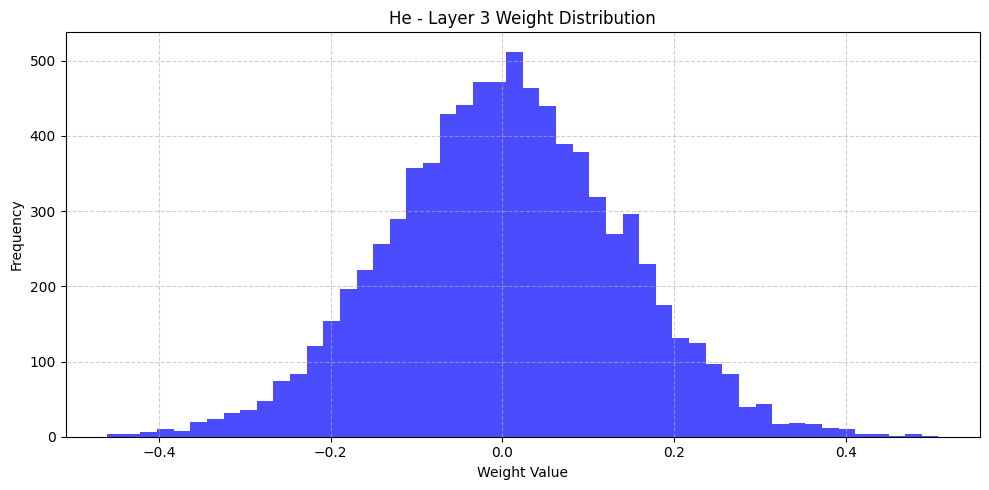

Weight stats for He - Layer 3:
  Mean: 0.003309
  Std Dev: 0.134852
  Min: -0.460079
  Max: 0.507547


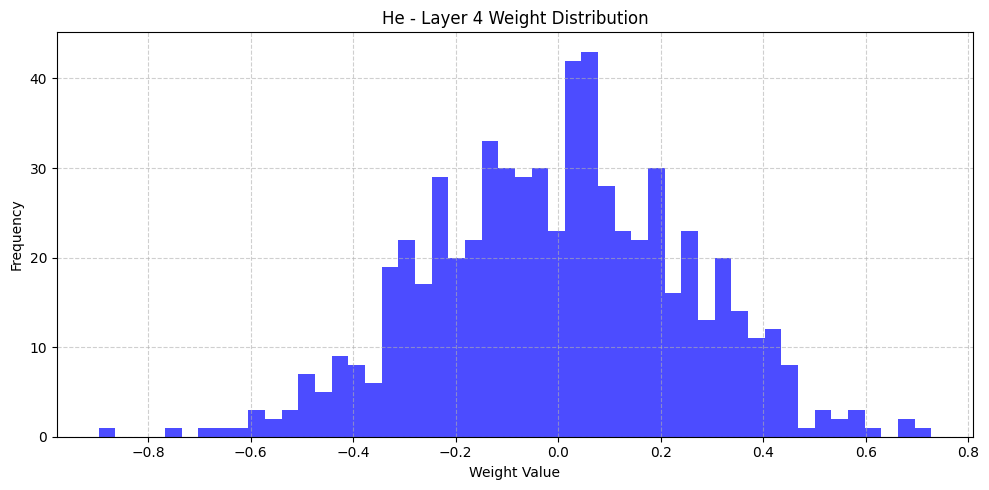

Weight stats for He - Layer 4:
  Mean: -0.002368
  Std Dev: 0.250039
  Min: -0.896786
  Max: 0.727670
No gradient (dW) attribute found for layer 1
No gradient (dW) attribute found for layer 2
No gradient (dW) attribute found for layer 3
No gradient (dW) attribute found for layer 4

===== Weight Initialization - Normal =====


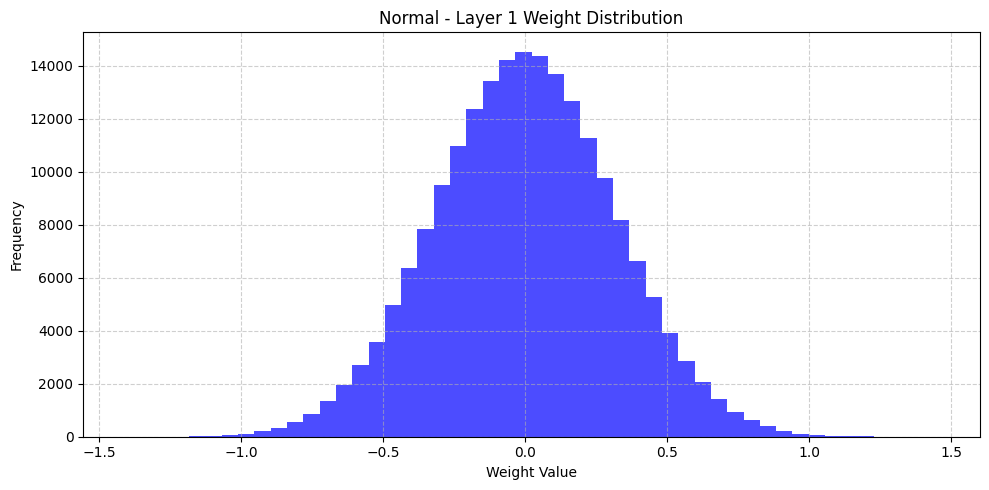

Weight stats for Normal - Layer 1:
  Mean: -0.000297
  Std Dev: 0.315984
  Min: -1.412867
  Max: 1.457941


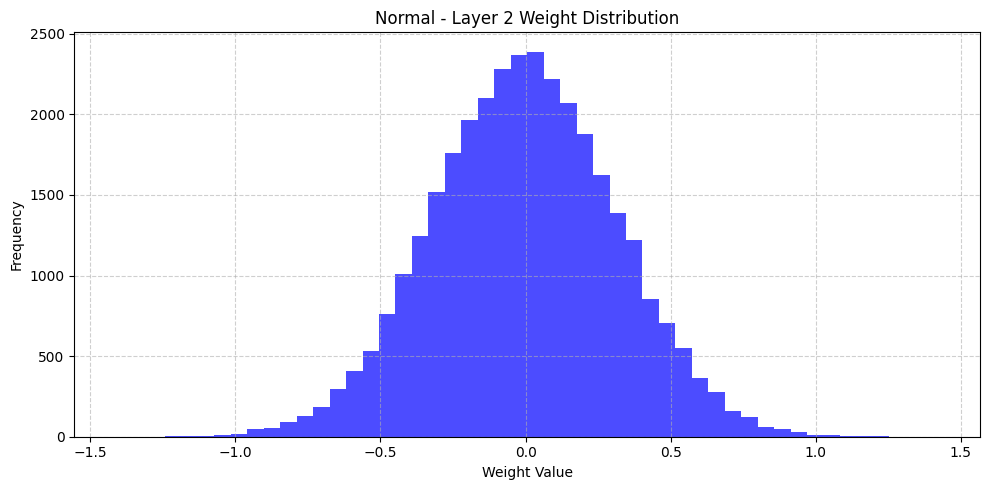

Weight stats for Normal - Layer 2:
  Mean: -0.003982
  Std Dev: 0.315155
  Min: -1.412965
  Max: 1.424104


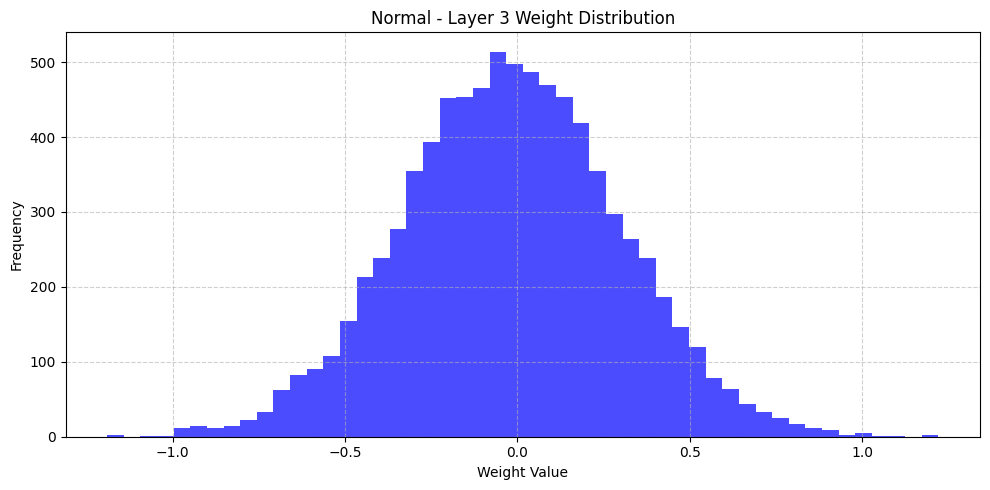

Weight stats for Normal - Layer 3:
  Mean: -0.018054
  Std Dev: 0.314232
  Min: -1.189749
  Max: 1.221749


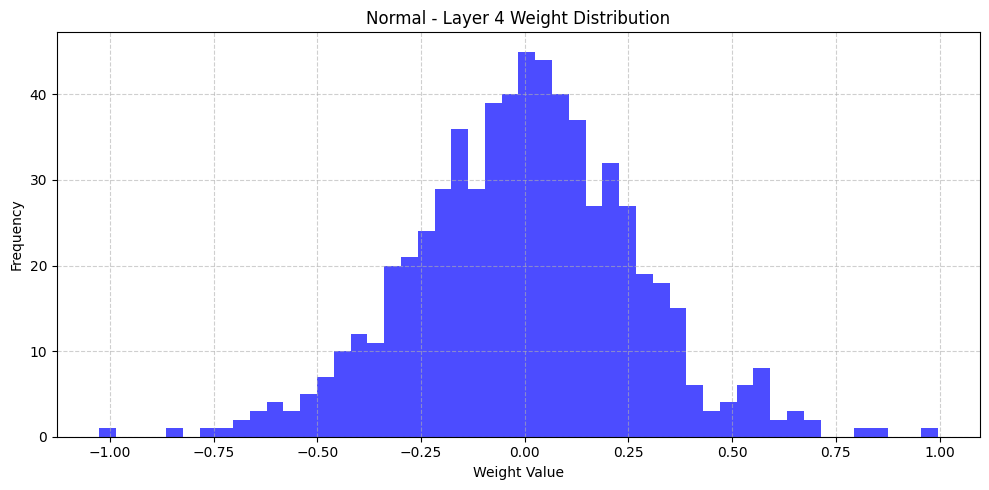

Weight stats for Normal - Layer 4:
  Mean: -0.001617
  Std Dev: 0.268234
  Min: -1.026706
  Max: 0.996387
No gradient (dW) attribute found for layer 1
No gradient (dW) attribute found for layer 2
No gradient (dW) attribute found for layer 3
No gradient (dW) attribute found for layer 4


In [11]:
# 4. Experiment: Weight Initialization
print("\n===== EXPERIMENT: WEIGHT INITIALIZATION =====")

init_configs = [
    {'init': 'xavier', 'name': 'Xavier'},
    {'init': 'zero', 'name': 'Zero'},
    {'init': 'uniform', 'name': 'Uniform'},
    {'init': 'he', 'name': 'He'},
    {'init': 'normal', 'name': 'Normal'}
]

init_results = {}
for cfg in init_configs:
    print(f"\nTraining model with {cfg['name']} initialization...")
    modified_config = copy.deepcopy(base_config)
    modified_config['model']['weight_init'] = cfg['init']
    model, history, accs = train_and_evaluate(modified_config)
    init_results[cfg['name']] = {'history': history, 'accs': accs, 'model': model}

plot_loss_histories(init_results, "Weight Initialization")
summarize_results(init_results, 'Accuracy Comparison (Weight Initialization)')
visualize_model_distributions(init_results, "Weight Initialization")


===== EXPERIMENT: REGULARIZATION =====

Training model with No Regularization...


Epoch 1/10: 100%|██████████| 1500/1500 [00:04<00:00, 309.25it/s]


 - train_loss: 0.7237 - val_loss: 0.3273


Epoch 2/10: 100%|██████████| 1500/1500 [00:03<00:00, 396.89it/s]


 - train_loss: 0.2846 - val_loss: 0.2516


Epoch 3/10: 100%|██████████| 1500/1500 [00:03<00:00, 421.47it/s]


 - train_loss: 0.2264 - val_loss: 0.2111


Epoch 4/10: 100%|██████████| 1500/1500 [00:03<00:00, 405.49it/s]


 - train_loss: 0.1880 - val_loss: 0.1815


Epoch 5/10: 100%|██████████| 1500/1500 [00:03<00:00, 423.94it/s]


 - train_loss: 0.1602 - val_loss: 0.1619


Epoch 6/10: 100%|██████████| 1500/1500 [00:04<00:00, 353.05it/s]


 - train_loss: 0.1379 - val_loss: 0.1497


Epoch 7/10: 100%|██████████| 1500/1500 [00:04<00:00, 328.62it/s]


 - train_loss: 0.1210 - val_loss: 0.1380


Epoch 8/10: 100%|██████████| 1500/1500 [00:04<00:00, 313.28it/s]


 - train_loss: 0.1068 - val_loss: 0.1229


Epoch 9/10: 100%|██████████| 1500/1500 [00:04<00:00, 335.68it/s]


 - train_loss: 0.0952 - val_loss: 0.1155


Epoch 10/10: 100%|██████████| 1500/1500 [00:04<00:00, 342.16it/s]


 - train_loss: 0.0850 - val_loss: 0.1141

Training model with L1 Regularization...


Epoch 1/10: 100%|██████████| 1500/1500 [00:04<00:00, 302.83it/s]


 - train_loss: 0.6922 - val_loss: 0.3124


Epoch 2/10: 100%|██████████| 1500/1500 [00:04<00:00, 335.50it/s]


 - train_loss: 0.2773 - val_loss: 0.2402


Epoch 3/10: 100%|██████████| 1500/1500 [00:04<00:00, 340.16it/s]


 - train_loss: 0.2186 - val_loss: 0.1971


Epoch 4/10: 100%|██████████| 1500/1500 [00:04<00:00, 312.55it/s]


 - train_loss: 0.1798 - val_loss: 0.1741


Epoch 5/10: 100%|██████████| 1500/1500 [00:04<00:00, 338.73it/s]


 - train_loss: 0.1527 - val_loss: 0.1545


Epoch 6/10: 100%|██████████| 1500/1500 [00:04<00:00, 314.94it/s]


 - train_loss: 0.1320 - val_loss: 0.1425


Epoch 7/10: 100%|██████████| 1500/1500 [00:04<00:00, 352.73it/s]


 - train_loss: 0.1163 - val_loss: 0.1294


Epoch 8/10: 100%|██████████| 1500/1500 [00:04<00:00, 338.87it/s]


 - train_loss: 0.1020 - val_loss: 0.1196


Epoch 9/10: 100%|██████████| 1500/1500 [00:04<00:00, 353.30it/s]


 - train_loss: 0.0907 - val_loss: 0.1147


Epoch 10/10: 100%|██████████| 1500/1500 [00:04<00:00, 355.86it/s]


 - train_loss: 0.0814 - val_loss: 0.1205

Training model with L2 Regularization...


Epoch 1/10: 100%|██████████| 1500/1500 [00:04<00:00, 345.89it/s]


 - train_loss: 0.7301 - val_loss: 0.3207


Epoch 2/10: 100%|██████████| 1500/1500 [00:04<00:00, 349.79it/s]


 - train_loss: 0.2920 - val_loss: 0.2509


Epoch 3/10: 100%|██████████| 1500/1500 [00:04<00:00, 353.94it/s]


 - train_loss: 0.2339 - val_loss: 0.2116


Epoch 4/10: 100%|██████████| 1500/1500 [00:04<00:00, 353.05it/s]


 - train_loss: 0.1948 - val_loss: 0.1808


Epoch 5/10: 100%|██████████| 1500/1500 [00:04<00:00, 339.43it/s]


 - train_loss: 0.1665 - val_loss: 0.1759


Epoch 6/10: 100%|██████████| 1500/1500 [00:04<00:00, 333.56it/s]


 - train_loss: 0.1448 - val_loss: 0.1556


Epoch 7/10: 100%|██████████| 1500/1500 [00:04<00:00, 332.79it/s]


 - train_loss: 0.1281 - val_loss: 0.1341


Epoch 8/10: 100%|██████████| 1500/1500 [00:04<00:00, 301.98it/s]


 - train_loss: 0.1140 - val_loss: 0.1298


Epoch 9/10: 100%|██████████| 1500/1500 [00:04<00:00, 300.42it/s]


 - train_loss: 0.1011 - val_loss: 0.1184


Epoch 10/10: 100%|██████████| 1500/1500 [00:03<00:00, 417.55it/s]


 - train_loss: 0.0907 - val_loss: 0.1106


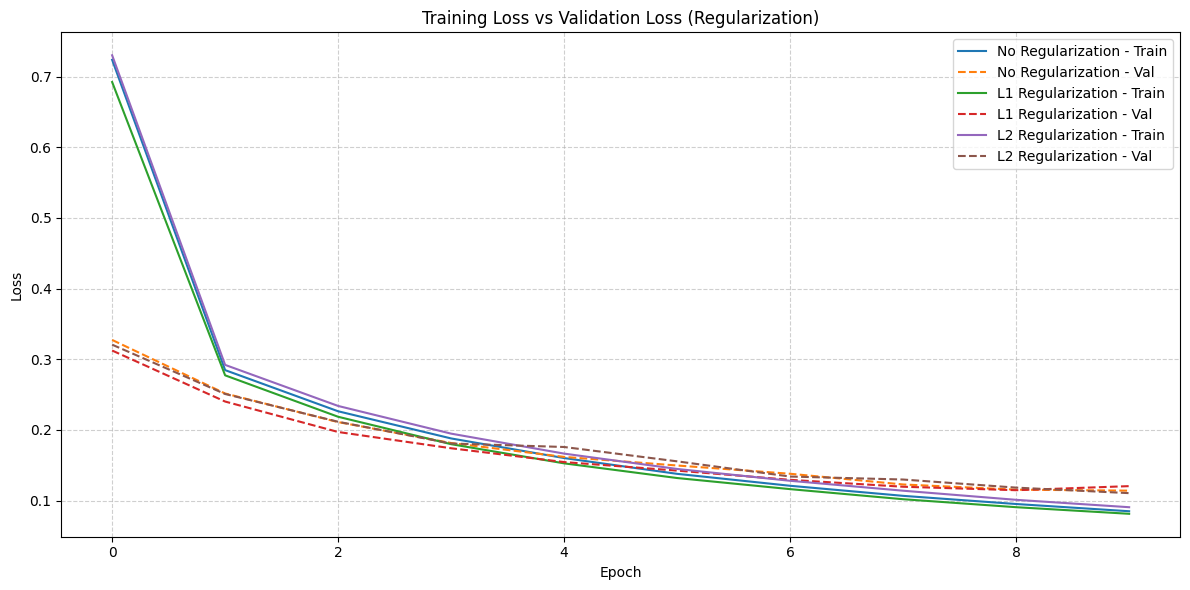

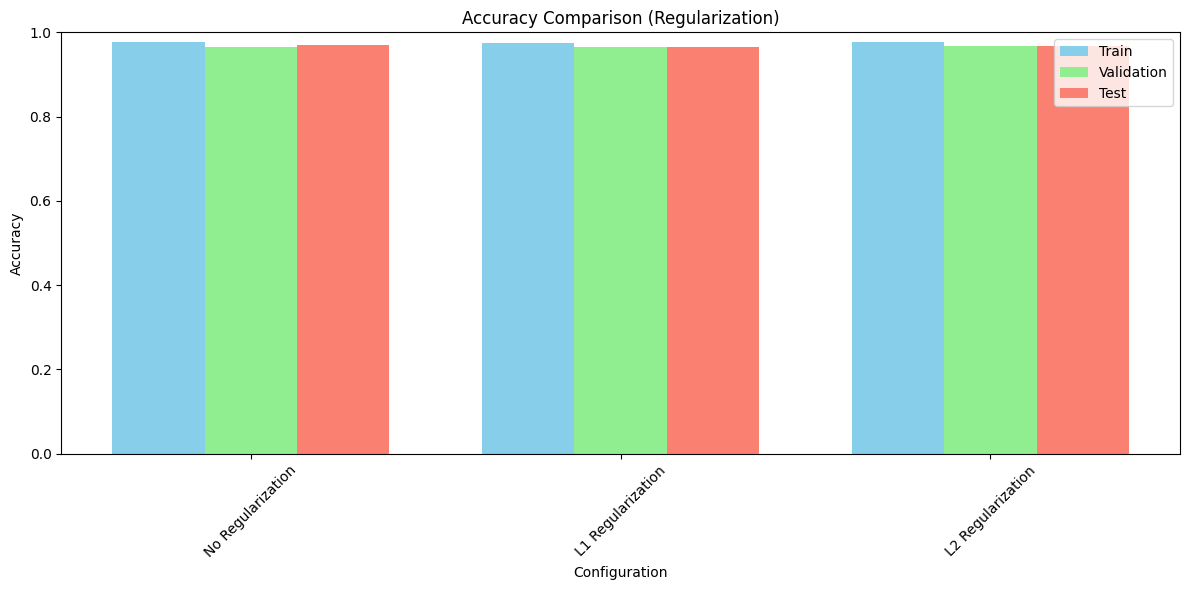


Detailed results:
Configuration        Train Acc  Val Acc    Test Acc  
--------------------------------------------------
No Regularization    0.9780     0.9657     0.9688
L1 Regularization    0.9746     0.9645     0.9647
L2 Regularization    0.9766     0.9674     0.9667

===== Regularization - No Regularization =====


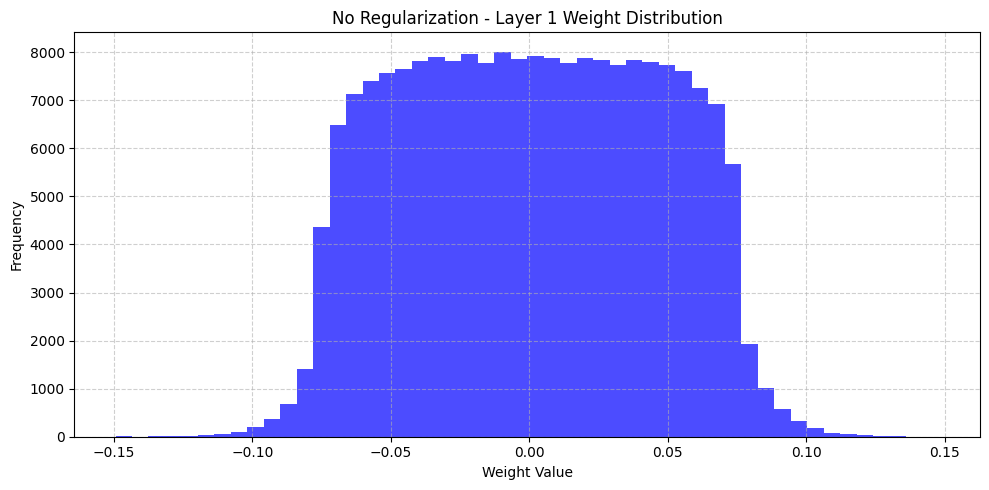

Weight stats for No Regularization - Layer 1:
  Mean: 0.000585
  Std Dev: 0.045121
  Min: -0.149412
  Max: 0.147886


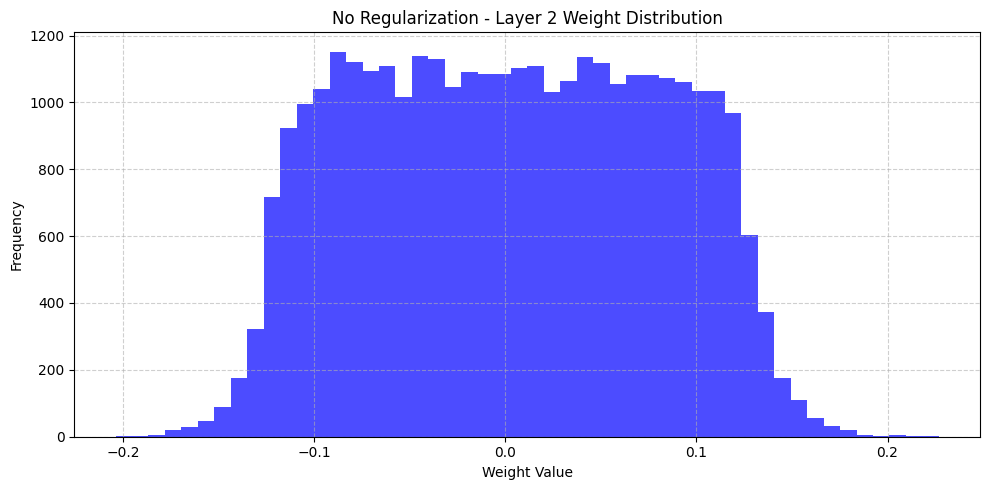

Weight stats for No Regularization - Layer 2:
  Mean: 0.002604
  Std Dev: 0.076595
  Min: -0.203979
  Max: 0.226856


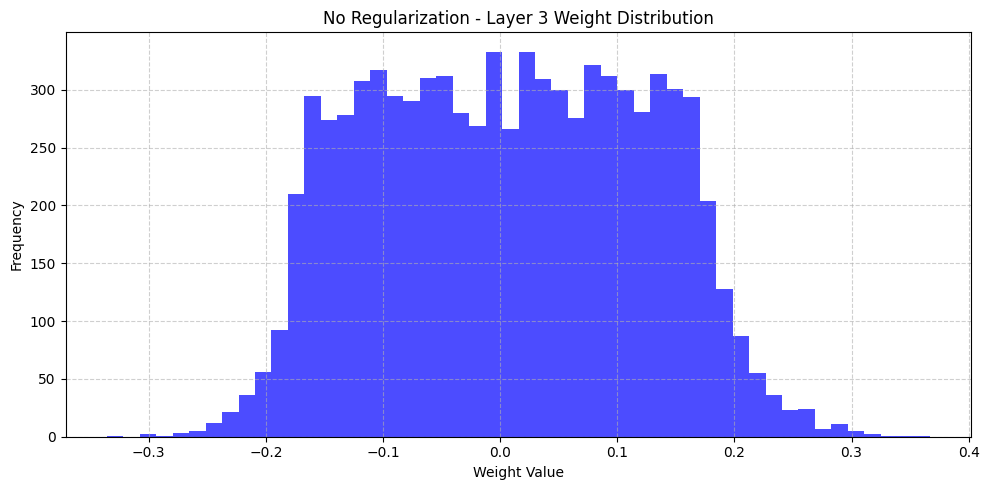

Weight stats for No Regularization - Layer 3:
  Mean: 0.006556
  Std Dev: 0.114886
  Min: -0.335744
  Max: 0.367165


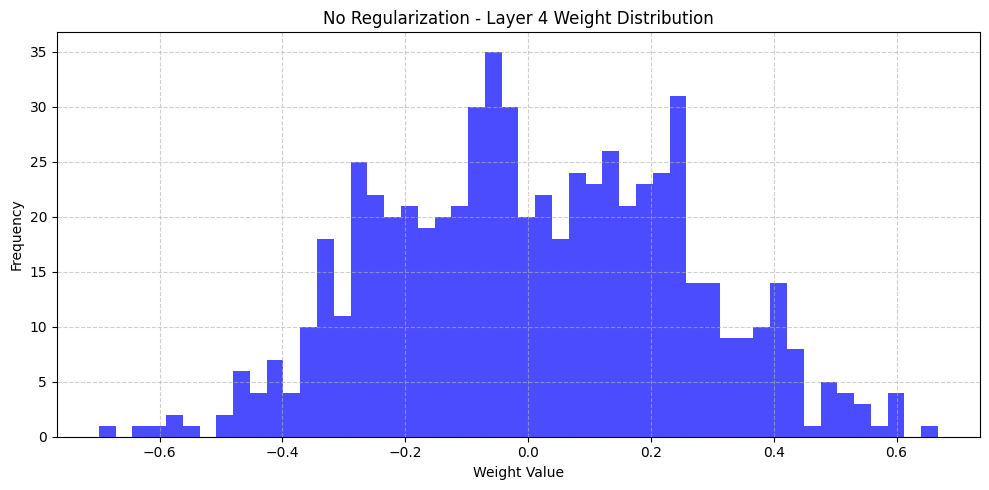

Weight stats for No Regularization - Layer 4:
  Mean: 0.009801
  Std Dev: 0.242675
  Min: -0.698870
  Max: 0.667465
No gradient (dW) attribute found for layer 1
No gradient (dW) attribute found for layer 2
No gradient (dW) attribute found for layer 3
No gradient (dW) attribute found for layer 4

===== Regularization - L1 Regularization =====


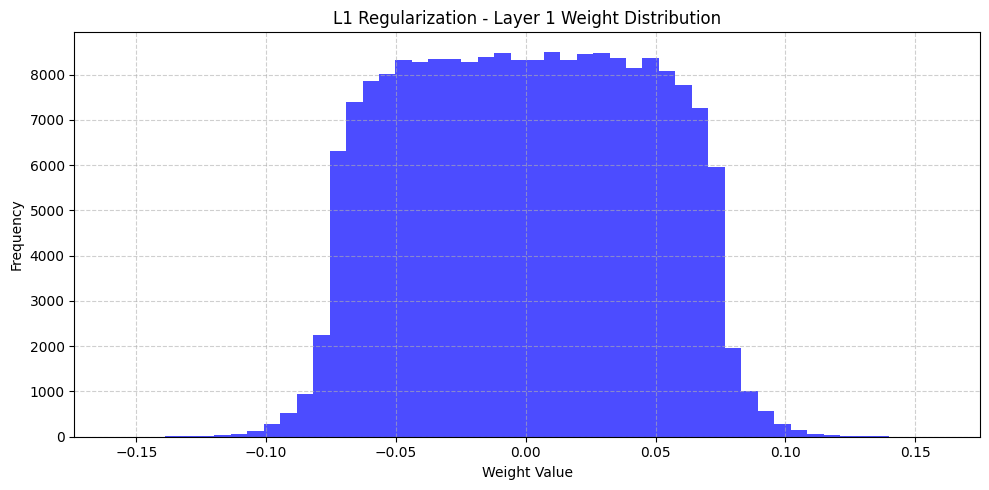

Weight stats for L1 Regularization - Layer 1:
  Mean: 0.000362
  Std Dev: 0.045142
  Min: -0.157972
  Max: 0.159127


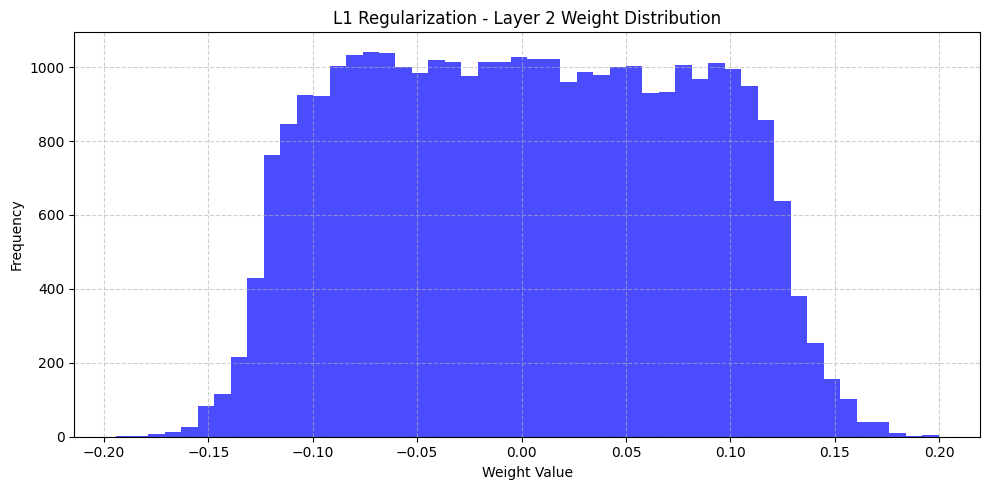

Weight stats for L1 Regularization - Layer 2:
  Mean: 0.002431
  Std Dev: 0.076399
  Min: -0.194375
  Max: 0.199749


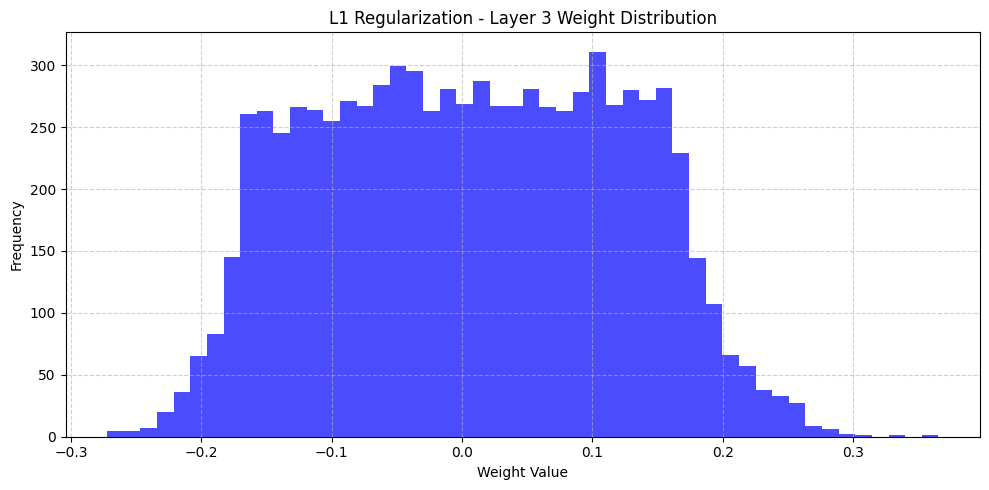

Weight stats for L1 Regularization - Layer 3:
  Mean: 0.006338
  Std Dev: 0.113732
  Min: -0.272344
  Max: 0.365561


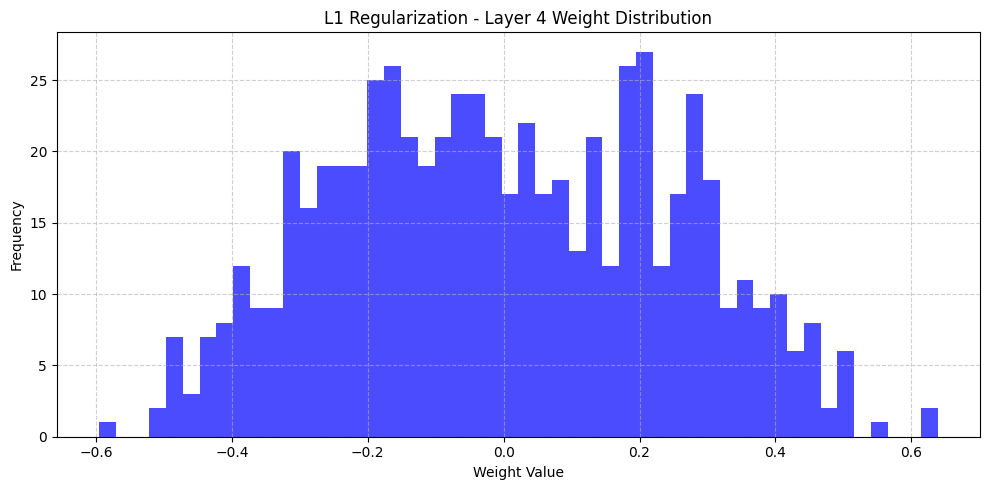

Weight stats for L1 Regularization - Layer 4:
  Mean: -0.001987
  Std Dev: 0.245134
  Min: -0.595659
  Max: 0.639320
No gradient (dW) attribute found for layer 1
No gradient (dW) attribute found for layer 2
No gradient (dW) attribute found for layer 3
No gradient (dW) attribute found for layer 4

===== Regularization - L2 Regularization =====


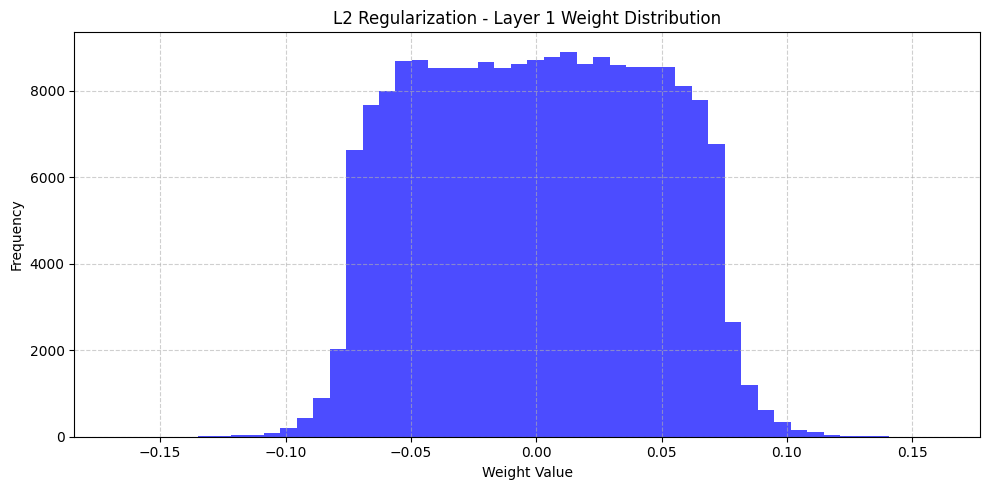

Weight stats for L2 Regularization - Layer 1:
  Mean: 0.000402
  Std Dev: 0.045123
  Min: -0.167785
  Max: 0.160579


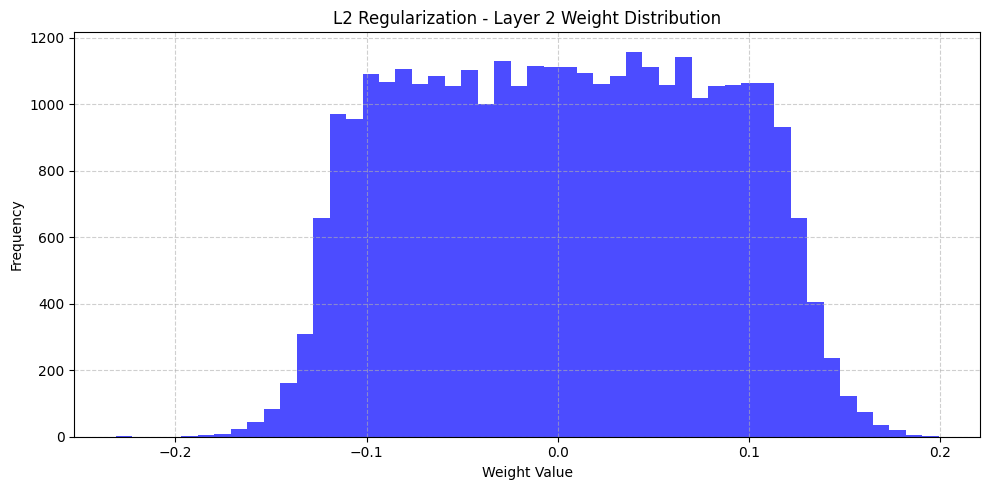

Weight stats for L2 Regularization - Layer 2:
  Mean: 0.002605
  Std Dev: 0.076702
  Min: -0.231357
  Max: 0.199436


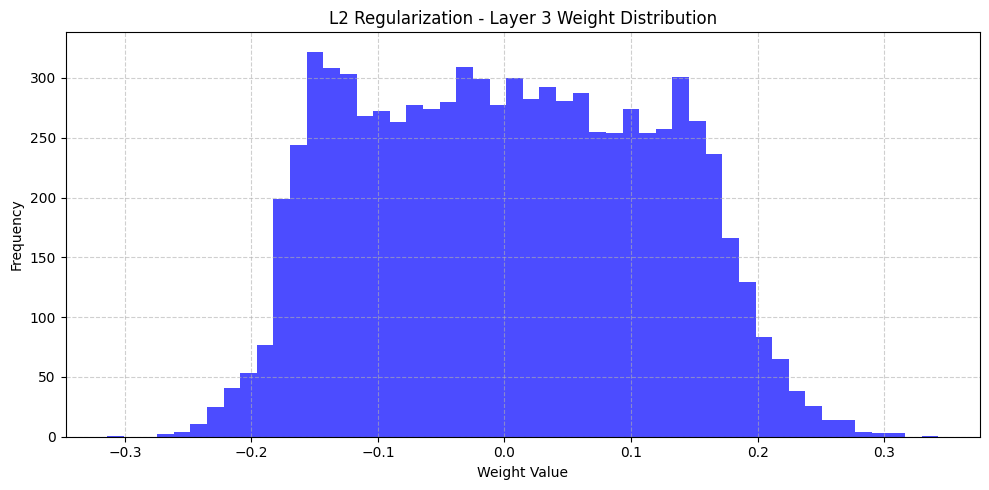

Weight stats for L2 Regularization - Layer 3:
  Mean: 0.002647
  Std Dev: 0.114559
  Min: -0.313883
  Max: 0.342855


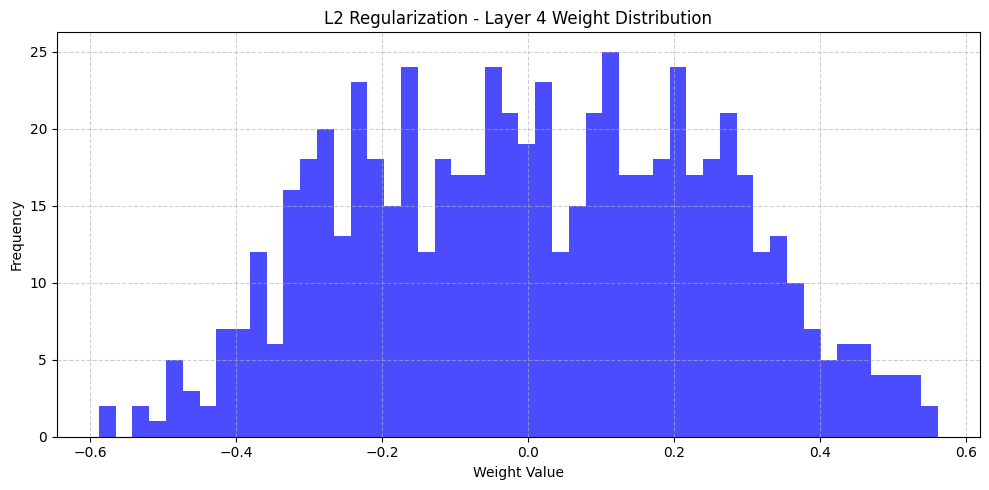

Weight stats for L2 Regularization - Layer 4:
  Mean: 0.008702
  Std Dev: 0.243744
  Min: -0.587723
  Max: 0.561943
No gradient (dW) attribute found for layer 1
No gradient (dW) attribute found for layer 2
No gradient (dW) attribute found for layer 3
No gradient (dW) attribute found for layer 4


In [12]:
# 5. Experiment: Regularization
print("\n===== EXPERIMENT: REGULARIZATION =====")

reg_configs = [
    {'name': 'No Regularization', 'lambda_l1': 0.0, 'lambda_l2': 0.0},
    {'name': 'L1 Regularization', 'lambda_l1': 0.0001, 'lambda_l2': 0.0},
    {'name': 'L2 Regularization', 'lambda_l1': 0.0, 'lambda_l2': 0.0001}
]

reg_results = {}
for cfg in reg_configs:
    print(f"\nTraining model with {cfg['name']}...")
    
    # Create model with base parameters from config
    model = FeedForwardNN(
        input_size=base_config['model']['input_size'],
        hidden_layers=base_config['model']['hidden_layers'],
        output_size=base_config['model']['output_size'],
        activations=base_config['model']['activations'],
        weight_init=base_config['model']['weight_init'],
        weight_init_params=base_config.get('weight_init_params', None),
        loss_function=base_config['model']['loss_function']
    )
    
    # Set regularization directly on the model
    if hasattr(model, 'set_regularization'):
        if cfg['lambda_l1'] > 0:
            model.set_regularization('l1', cfg['lambda_l1'])
        elif cfg['lambda_l2'] > 0:
            model.set_regularization('l2', cfg['lambda_l2'])
    
    # Train model
    history = model.train(
        X_train, y_train,
        X_val=X_val, y_val=y_val,
        batch_size=base_config['training']['batch_size'],
        learning_rate=base_config['training']['learning_rate'],
        epochs=base_config['training']['epochs'],
        verbose=base_config['training']['verbose']
    )
    
    # Evaluate model
    train_acc = compute_accuracy(model, X_train, y_train)
    val_acc = compute_accuracy(model, X_val, y_val)
    test_acc = compute_accuracy(model, X_test, y_test)
    
    reg_results[cfg['name']] = {
        'history': history, 
        'accs': (train_acc, val_acc, test_acc), 
        'model': model
    }

plot_loss_histories(reg_results, "Regularization")
summarize_results(reg_results, 'Accuracy Comparison (Regularization)')
visualize_model_distributions(reg_results, "Regularization")


===== COMPARISON WITH SKLEARN MLP =====

Training custom FFNN model...


Epoch 1/10: 100%|██████████| 1500/1500 [00:03<00:00, 399.68it/s]


 - train_loss: 0.6913 - val_loss: 0.3231


Epoch 2/10: 100%|██████████| 1500/1500 [00:03<00:00, 390.60it/s]


 - train_loss: 0.2865 - val_loss: 0.2443


Epoch 3/10: 100%|██████████| 1500/1500 [00:03<00:00, 381.74it/s]


 - train_loss: 0.2260 - val_loss: 0.2050


Epoch 4/10: 100%|██████████| 1500/1500 [00:03<00:00, 408.08it/s]


 - train_loss: 0.1871 - val_loss: 0.1857


Epoch 5/10: 100%|██████████| 1500/1500 [00:03<00:00, 409.90it/s]


 - train_loss: 0.1589 - val_loss: 0.1565


Epoch 6/10: 100%|██████████| 1500/1500 [00:04<00:00, 354.96it/s]


 - train_loss: 0.1385 - val_loss: 0.1400


Epoch 7/10: 100%|██████████| 1500/1500 [00:04<00:00, 347.00it/s]


 - train_loss: 0.1218 - val_loss: 0.1342


Epoch 8/10: 100%|██████████| 1500/1500 [00:04<00:00, 361.80it/s]


 - train_loss: 0.1087 - val_loss: 0.1235


Epoch 9/10: 100%|██████████| 1500/1500 [00:04<00:00, 358.34it/s]


 - train_loss: 0.0970 - val_loss: 0.1152


Epoch 10/10: 100%|██████████| 1500/1500 [00:04<00:00, 364.10it/s]


 - train_loss: 0.0875 - val_loss: 0.1078

Training sklearn MLP model...


c:\Users\ASUS\OneDrive - Institut Teknologi Bandung\Semester 6\Machine Learning\Tubes 1\feedforward-neural-network\src\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(



Accuracy Comparison:
                  Train       Validation  Test
Custom FFNN:      0.9796    0.9675    0.9684
Sklearn MLP:      0.9819    0.9660    0.9681


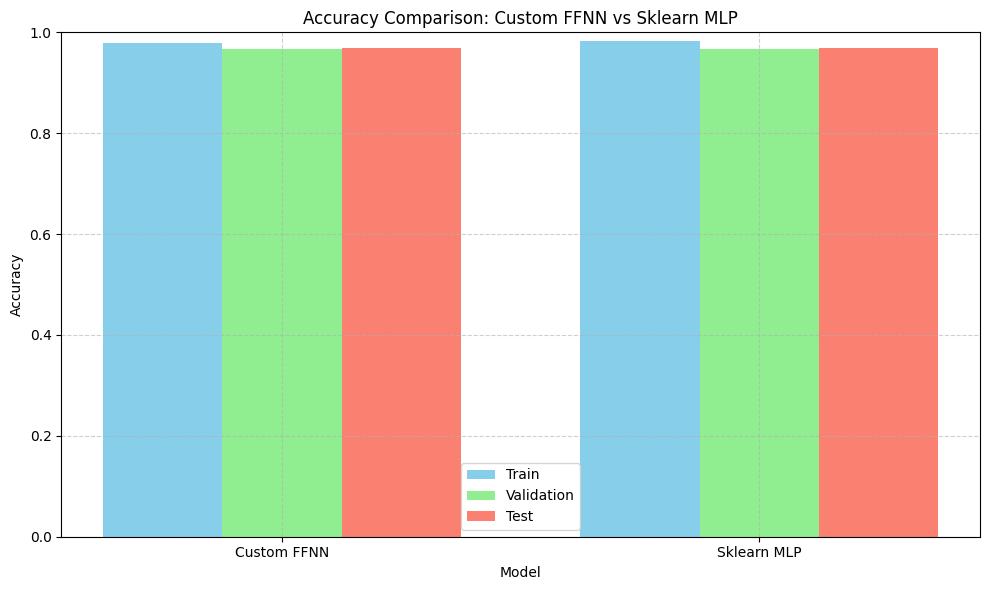


===== ALL EXPERIMENTS COMPLETED =====


In [13]:
# 6. Comparison with Sklearn MLP
print("\n===== COMPARISON WITH SKLEARN MLP =====")

# Train our custom FFNN model with the base configuration
print("\nTraining custom FFNN model...")
ffnn_model, ffnn_history, (ffnn_train_acc, ffnn_val_acc, ffnn_test_acc) = train_and_evaluate(base_config)

# Train sklearn's MLPClassifier with similar parameters
print("\nTraining sklearn MLP model...")
mlp = MLPClassifier(
    hidden_layer_sizes=tuple(base_config['model']['hidden_layers']),
    activation='relu',
    solver='adam',
    alpha=base_config['model'].get('lambda_l2', 0.0001),  # L2 regularization
    learning_rate_init=base_config['training']['learning_rate'],
    max_iter=base_config['training']['epochs'],
    batch_size=base_config['training']['batch_size'],
    random_state=42
)

mlp.fit(X_train, np.argmax(y_train, axis=1))
sklearn_train_acc = mlp.score(X_train, np.argmax(y_train, axis=1))
sklearn_val_acc = mlp.score(X_val, np.argmax(y_val, axis=1))
sklearn_test_acc = mlp.score(X_test, np.argmax(y_test, axis=1))

# Compare results
print(f"\nAccuracy Comparison:")
print(f"                  Train       Validation  Test")
print(f"Custom FFNN:      {ffnn_train_acc:.4f}    {ffnn_val_acc:.4f}    {ffnn_test_acc:.4f}")
print(f"Sklearn MLP:      {sklearn_train_acc:.4f}    {sklearn_val_acc:.4f}    {sklearn_test_acc:.4f}")

# Visualize comparison
plt.figure(figsize=(10, 6))
models = ['Custom FFNN', 'Sklearn MLP']
train_accs = [ffnn_train_acc, sklearn_train_acc]
val_accs = [ffnn_val_acc, sklearn_val_acc]
test_accs = [ffnn_test_acc, sklearn_test_acc]

x = np.arange(len(models))
width = 0.25

plt.bar(x - width, train_accs, width, label='Train', color='skyblue')
plt.bar(x, val_accs, width, label='Validation', color='lightgreen')
plt.bar(x + width, test_accs, width, label='Test', color='salmon')

plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison: Custom FFNN vs Sklearn MLP')
plt.xticks(x, models)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\n===== ALL EXPERIMENTS COMPLETED =====")